**UNR - TUIA**

# Trabajo Prático N°: 2 - Aprendizaje Automático

### Integrantes:
*   Crenna, Giuliano. Legajo: C-7438/1.
*   Pace, Bruno. Legajo: P-5295/7.
*   Sancho Almenar, Mariano. Legajo: S-5778/9.

Chequeo si estoy en google colab o no, por una cuestión de prolijidad del código y evitar modificaciones continuas dependiendo el entorno de ejecución.

In [122]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
  !wget -O 'weatherAUS.csv' 'https://github.com/bpace1/AA1-TUIA-Crenna-Pace-SanchoAlmenar/raw/b320c97cfe71557d3a340ecf3ad424656cd69d49/data/weatherAUS.csv'
  !wget -O 'requirements.txt' 'https://github.com/bpace1/AA1-TUIA-Crenna-Pace-SanchoAlmenar/raw/b320c97cfe71557d3a340ecf3ad424656cd69d49/requirements.txt'

  !pip install -r requirements.txt;
  DATASET_PATH: str = 'weatherAUS.csv'
  MODEL_PATH: str = '/content/'
else:
  DATASET_PATH: str = os.path.join(os.getcwd(), 'data', 'weatherAUS.csv')
  MODEL_PATH: str = 'Docker/models/'

--2024-12-31 17:22:20--  https://github.com/bpace1/AA1-TUIA-Crenna-Pace-SanchoAlmenar/raw/b320c97cfe71557d3a340ecf3ad424656cd69d49/data/weatherAUS.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bpace1/AA1-TUIA-Crenna-Pace-SanchoAlmenar/b320c97cfe71557d3a340ecf3ad424656cd69d49/data/weatherAUS.csv [following]
--2024-12-31 17:22:20--  https://raw.githubusercontent.com/bpace1/AA1-TUIA-Crenna-Pace-SanchoAlmenar/b320c97cfe71557d3a340ecf3ad424656cd69d49/data/weatherAUS.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14094055 (13M) [text/plain]
Saving to: ‘weatherAUS.csv’

weatherAUS.csv      1

In [2]:
#Tratamiento de datos:
import numpy as np
import pandas as pd
import math

#Gráficos:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Preprocesado y modelado:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, make_scorer, accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from pycaret.classification import *
from imblearn.over_sampling import ADASYN
import tensorflow as tf
import optuna
import shap
import random
import joblib
import pickle

from typing import Dict, List, Tuple, Any, Generator
import os

#Configuración de warnings:
import warnings
warnings.filterwarnings('ignore')

# Ignore UserWarning related to 'penalty=None' and ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning, message="Setting penalty=None will ignore the C and l1_ratio parameters")
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [3]:
df_pure: pd.DataFrame = pd.read_csv(DATASET_PATH)
df: pd.DataFrame = df_pure.copy()

# EDA

El df cuenta con datos de las condiciones climáticas de diferentes ciudades, día a día en distintos años. Nuestro interés es la predicción de lluvia al siguiente día. Destacamos que contamos con una variable que indica si llovió al día siguiente o no.

Se elige una semilla para que sean siempre las mismas 10 ciudades.

In [4]:
random.seed(42)
choosen_cities: List[str] = random.sample(df['Location'].unique().tolist(), k=10)

In [5]:
df: pd.DataFrame = df[df['Location'].isin(choosen_cities)].reset_index(drop = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30818 entries, 0 to 30817
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           30818 non-null  object 
 1   Location       30818 non-null  object 
 2   MinTemp        30254 non-null  float64
 3   MaxTemp        30421 non-null  float64
 4   Rainfall       30243 non-null  float64
 5   Evaporation    10686 non-null  float64
 6   Sunshine       10127 non-null  float64
 7   WindGustDir    26779 non-null  object 
 8   WindGustSpeed  26797 non-null  float64
 9   WindDir9am     27071 non-null  object 
 10  WindDir3pm     28746 non-null  object 
 11  WindSpeed9am   29921 non-null  float64
 12  WindSpeed3pm   29269 non-null  float64
 13  Humidity9am    29837 non-null  float64
 14  Humidity3pm    29348 non-null  float64
 15  Pressure9am    21206 non-null  float64
 16  Pressure3pm    21250 non-null  float64
 17  Cloud9am       15523 non-null  float64
 18  Cloud3

### Descripción de Variables

1. *Date*: Fecha de la medición.
2. *Location*: Lugar donde se tomaron las mediciones.
3. *MinTemp*: Temperatura mínima del día.
4. *MaxTemp*: Temperatura máxima del día.
5. *Rainfall*: Cantidad de lluvia registrada (en mm).
6. *Evaporation*: Cantidad de agua evaporada (en mm).
7. *Sunshine*: Horas de luz solar en el día.
8. *WindGustDir*: Dirección del viento más fuerte del día.
9. *WindGustSpeed*: Velocidad del viento más fuerte (en km/h).
10. *WindDir9am*: Dirección del viento a las 9 AM.
11. *WindDir3pm*: Dirección del viento a las 3 PM.
12. *WindSpeed9am*: Velocidad del viento a las 9 AM (en km/h).
13. *WindSpeed3pm*: Velocidad del viento a las 3 PM (en km/h).
14. *Humidity9am*: Humedad relativa a las 9 AM.
15. *Humidity3pm*: Humedad relativa a las 3 PM.
16. *Pressure9am*: Presión atmosférica a las 9 AM.
17. *Pressure3pm*: Presión atmosférica a las 3 PM.
18. *Cloud9am*: Cobertura nubosa a las 9 AM.
19. *Cloud3pm*: Cobertura nubosa a las 3 PM.
20. *Temp9am*: Temperatura a las 9 AM.
21. *Temp3pm*: Temperatura a las 3 PM.
22. *RainToday*: Indica si llovió el día de la medición (Sí/No).
23. *RainTomorrow*: Indica si lloverá el día siguiente (Sí/No).

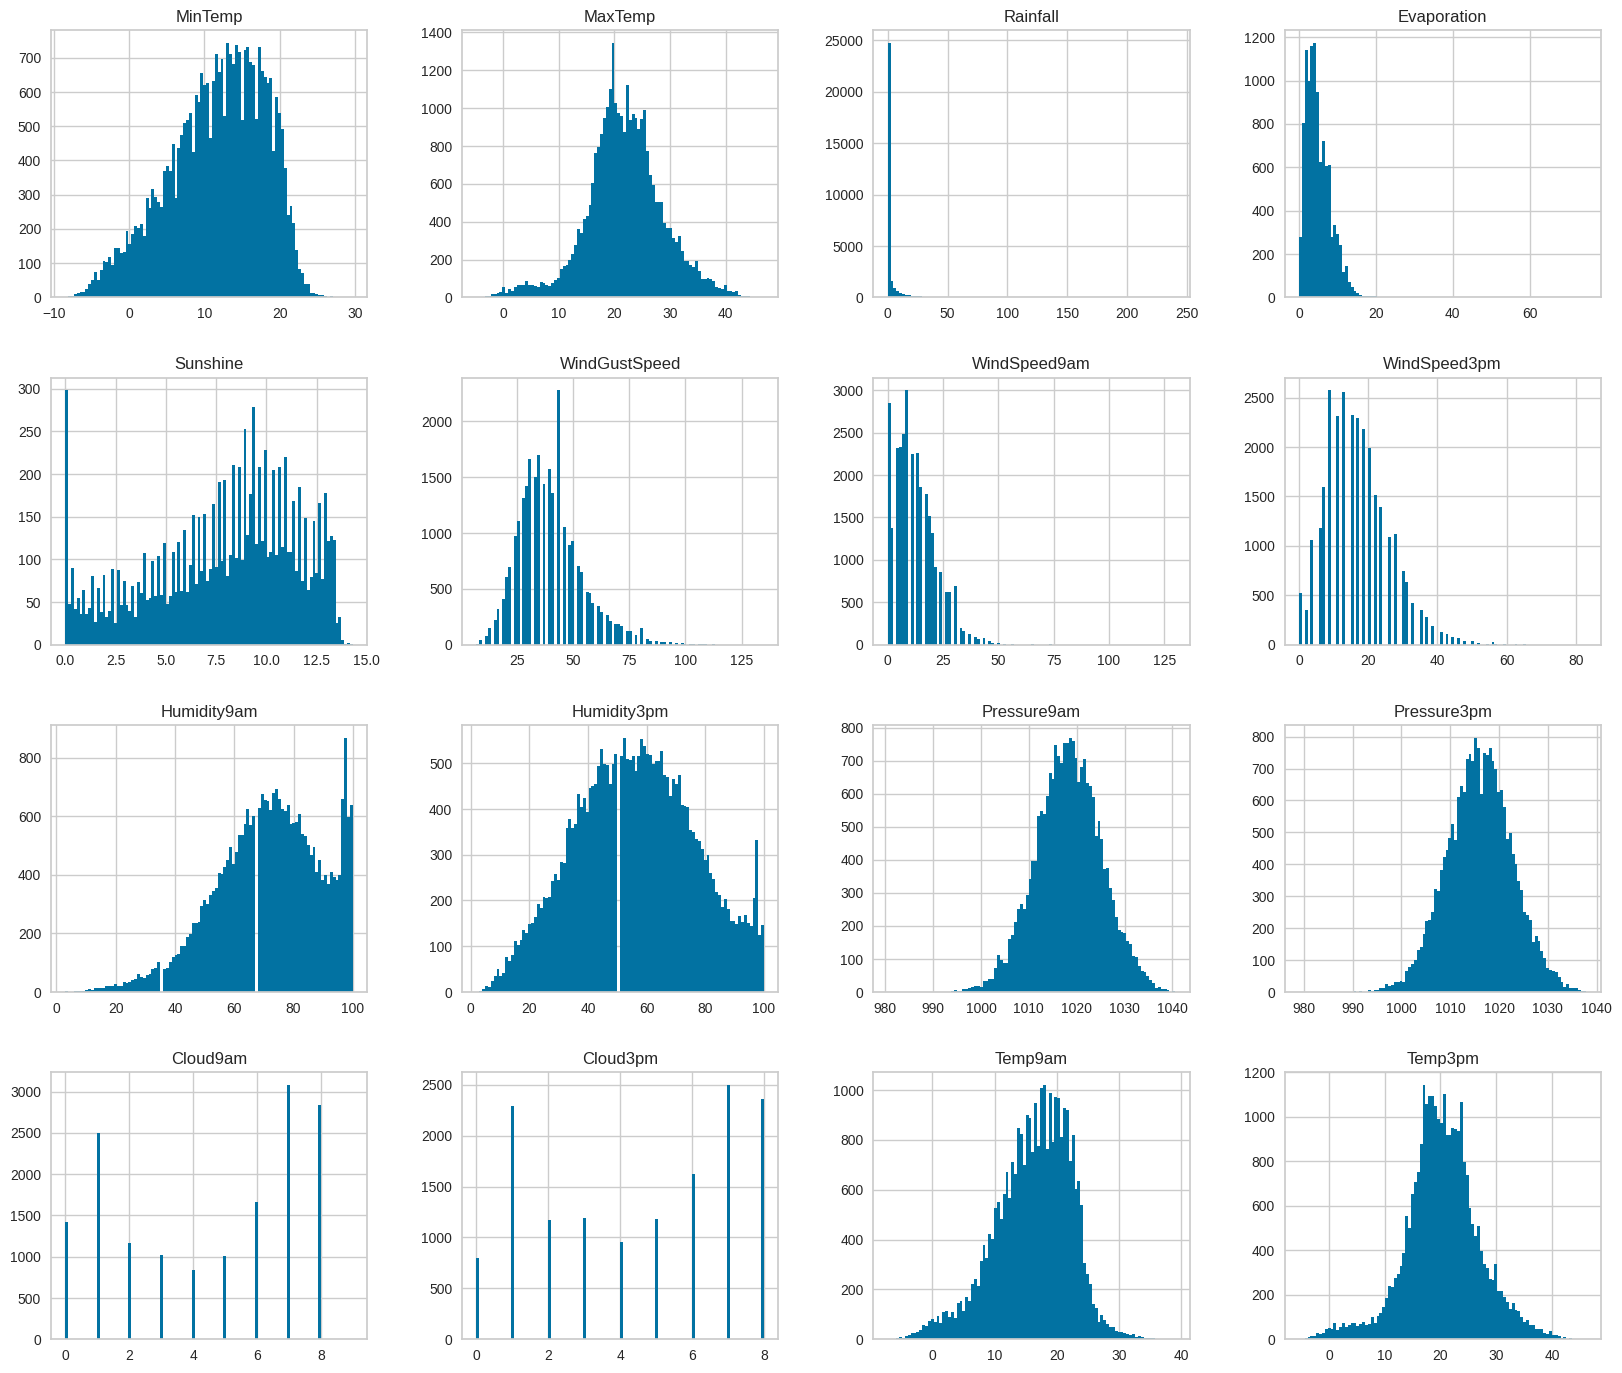

In [7]:
df.hist(figsize= (20,17), bins=100);

La mayoria de las variables presentan distribuciones normales, exceptuando:

- *Rainfall*, *Evaporation*, *WindSpeed3pm*, *Windspeed9am*, *WindGustSpeed* presentan una distribucion asimetrica a la derecha

**Preprocesado:**
1. Convertimos la variable Date a tipo datetime.

In [8]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

### Series temporales
Es importante observar cómo las temperaturas y precipitaciones varían con el tiempo.

Como podemos observar las series de tiempo de las temperaturas mínimas y máximas son estrictamente estacionales. Mientras que las precipitaciones no presentan estacionalidad.

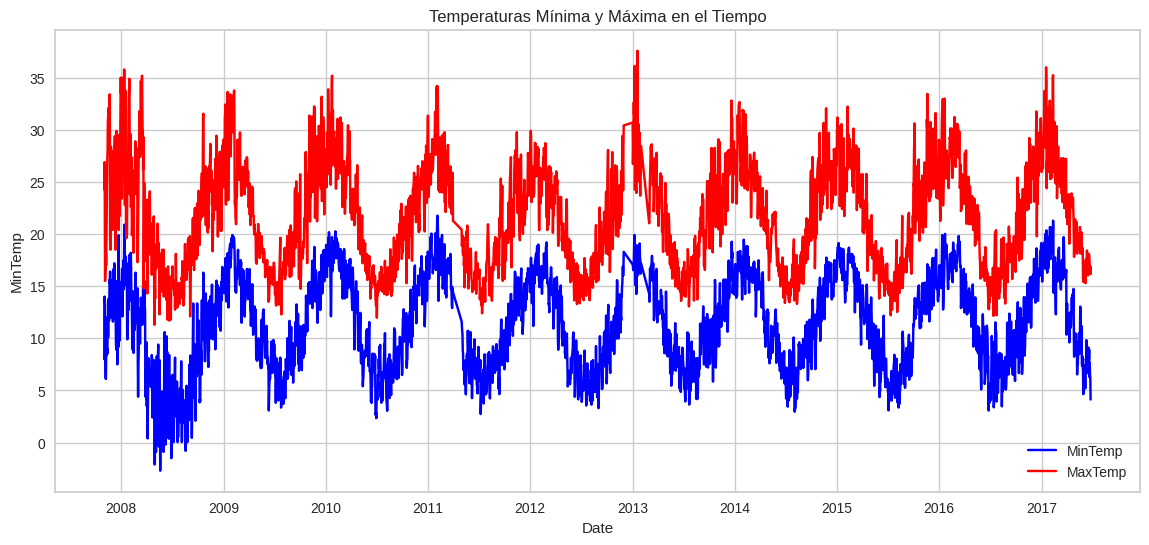

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='MinTemp', data=df, label='MinTemp', color='blue', ci=None)
sns.lineplot(x='Date', y='MaxTemp', data=df, label='MaxTemp', color='red', ci=None)
plt.title("Temperaturas Mínima y Máxima en el Tiempo")
plt.show()

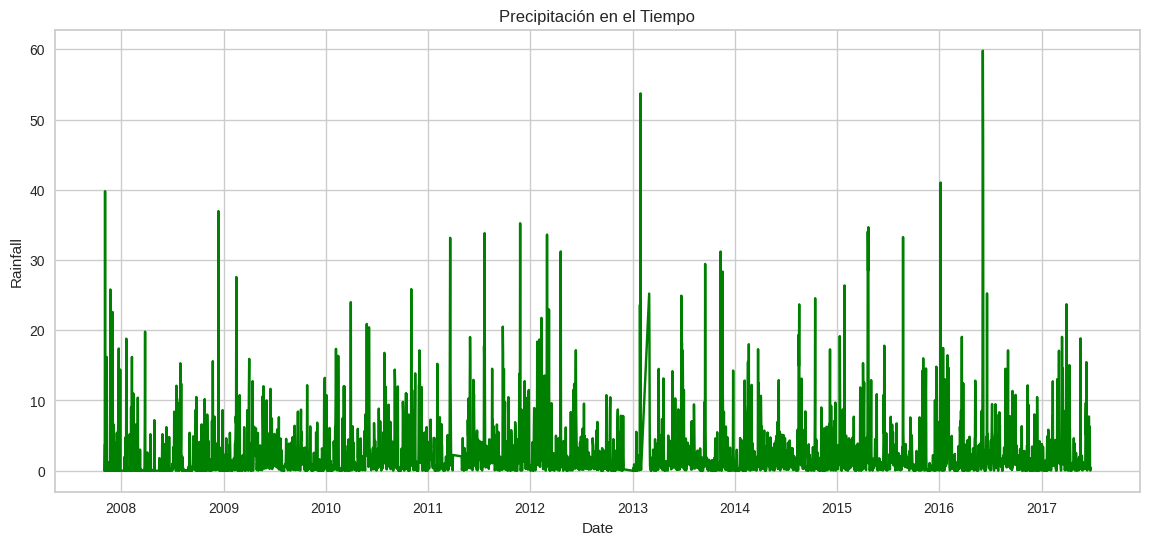

In [10]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Rainfall', data=df, color='green', ci=None)
plt.title("Precipitación en el Tiempo")
plt.show()


### Date

Dado que 'Date' se encuentra con formato 'YYYY-MM-DD', se dividirá en 2 columnas distintas.

- **Year**: Será una variable categórica indicando el año, luego se codificará utilizando One-Hot Encoder.
- **Season**:  Indicará en qué temporada del año ocurrió la medición.

In [11]:
df['Year'] = df['Date'].dt.year

df['Day'] = df['Date'].dt.dayofyear

In [12]:
df[['Date', 'Year', 'Day']].sample(2)

,Date,Year,Day
1790,2014-02-23,2014,54
29519,2013-12-05,2013,339


In [13]:
df.drop(columns= 'Date', inplace=True)


### Mediciones del viento

Las columnas *WindGustDir*, *WindDir9am*, *WindDir3pm*, *WindSpeed3pm* indican la dirección del viento utilizando las direcciones cardinales.

Se transformarán dichas direcciones en las proyecciones que tienen sobre los ejes x e y.

In [14]:
def angle_to_xy(angle: float) -> Tuple[np.float64, np.float64]:
    """
    Función que recibe la dirección del viento en grados y la transformará en projecciones sobre el eje x e y,
    obteniendo así dos valores numéricos por cada columna.
    """

    if math.isnan(angle):
        return (np.nan, np.nan)

    # Convertimos el ángulo a radianes
    angle_rad = math.radians(angle)


    x = math.sin(angle_rad)
    y = math.cos(angle_rad)

    return (x, y)

In [15]:
direction_angles: dict[str, float] = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
}

columnas_viento: List[str] = ['WindDir3pm','WindDir9am', 'WindGustDir']

for columna in columnas_viento:
    df[columna] = df[columna].map(direction_angles)

# Creamos las columnas con las projecciones x e y para los distintos vientos.
df[['WindDir3pm_x', 'WindDir3pm_y']] = df['WindDir3pm'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

df[['WindDir9am_x', 'WindDir9am_y']] = df['WindDir9am'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

df[['WindGustDir_x', 'WindGustDir_y']] = df['WindGustDir'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

In [16]:
df.drop(columns=columnas_viento , inplace=True)


### Columnas categóricas Yes/No

Se remplazan por valores 1 y 0

In [17]:
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

### Location

Para la localidad, se remplaza su valor con su respectiva coordenada


In [18]:
chosen_cities_coordinates: Dict [str, Dict[str, float]] = {
    "Newcastle": {"latitude": -32.9282, "longitude": 151.7817},
    "BadgerysCreek": {"latitude": -33.8836, "longitude": 150.7386},
    "Penrith": {"latitude": -33.7532, "longitude": 150.6880},
    "Perth": {"latitude": -31.9505, "longitude": 115.8605},
    "Canberra": {"latitude": -35.2809, "longitude": 149.1300},
    "Wollongong": {"latitude": -34.4278, "longitude": 150.8931},
    "Nuriootpa": {"latitude": -34.4658, "longitude": 138.9784},
    "NorahHead": {"latitude": -33.2886, "longitude": 151.6154},
    "NorfolkIsland": {"latitude": -29.0408, "longitude": 167.9547},
    "MountGinini": {"latitude": -35.4622, "longitude": 148.9525}
}


In [19]:
coords_df: pd.DataFrame = pd.DataFrame.from_dict(chosen_cities_coordinates, orient='index')
coords_df.reset_index(inplace=True)
coords_df.rename(columns={'index':'Location'}, inplace=True)
coords_df

,Location,latitude,longitude
0,Newcastle,-32.9282,151.7817
1,BadgerysCreek,-33.8836,150.7386
2,Penrith,-33.7532,150.6880
3,Perth,-31.9505,115.8605
4,Canberra,-35.2809,149.1300
5,Wollongong,-34.4278,150.8931
6,Nuriootpa,-34.4658,138.9784
7,NorahHead,-33.2886,151.6154
8,NorfolkIsland,-29.0408,167.9547
9,MountGinini,-35.4622,148.9525


In [20]:
df: pd.DataFrame = df.merge(coords_df, on='Location', how='left')
df: pd.DataFrame = df.drop(columns=['Location'])

In [21]:
df[['Year', 'Day', 'latitude', 'longitude', 'WindDir3pm_x', 'WindDir3pm_y', 'WindDir9am_x', 'WindDir9am_y','WindGustDir_x', 'WindGustDir_y' ,  'RainToday', 'RainTomorrow']].sample(50)

,Year,Day,latitude,longitude,WindDir3pm_x,WindDir3pm_y,WindDir9am_x,WindDir9am_y,WindGustDir_x,WindGustDir_y,RainToday,RainTomorrow
587,2010,223,-33.8836,150.7386,-7.071068e-01,7.071068e-01,-3.826834e-01,9.238795e-01,-7.071068e-01,7.071068e-01,1.0,0.0
8085,2014,306,-33.2886,151.6154,3.826834e-01,-9.238795e-01,-9.238795e-01,-3.826834e-01,7.071068e-01,-7.071068e-01,1.0,0.0
17800,2016,203,-34.4278,150.8931,7.071068e-01,-7.071068e-01,-7.071068e-01,-7.071068e-01,-3.826834e-01,-9.238795e-01,1.0,0.0
10379,2012,263,-29.0408,167.9547,9.238795e-01,-3.826834e-01,1.000000e+00,6.123234e-17,9.238795e-01,3.826834e-01,0.0,0.0
15163,2009,33,-34.4278,150.8931,7.071068e-01,7.071068e-01,3.826834e-01,9.238795e-01,7.071068e-01,7.071068e-01,0.0,0.0
24422,2016,349,-35.4622,148.9525,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,-7.071068e-01,7.071068e-01,0.0,1.0
22785,2012,114,-35.4622,148.9525,-9.238795e-01,3.826834e-01,-3.826834e-01,9.238795e-01,-7.071068e-01,7.071068e-01,1.0,1.0
2697,2016,231,-33.8836,150.7386,9.238795e-01,3.826834e-01,NaN,NaN,3.826834e-01,9.238795e-01,0.0,0.0
713,2010,349,-33.8836,150.7386,0.000000e+00,1.000000e+00,-3.826834e-01,9.238795e-01,9.238795e-01,-3.826834e-01,0.0,0.0
24143,2016,70,-35.4622,148.9525,3.826834e-01,9.238795e-01,-9.238795e-01,3.826834e-01,9.238795e-01,3.826834e-01,0.0,1.0


# ETL


## Division del conjunto

Separación test y train conforme a las convenciones del 70% para Train y 30% restante que se divide en un 15% para test y un 15% para validación.

In [22]:
X: pd.DataFrame = df.drop(columns='RainTomorrow')
y: pd.DataFrame = df[['RainTomorrow']] #Variable a predecir

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Tratamiento de outliers



Teniendo en cuenta los análisis previos, se toma como criterio que los valores fuera del rango definido por ${Q1−1.5×IQR}$  y ${Q3+1.5×IQR}$
y son considerados outliers.  Completamos esos outliers por la mediana. El enfoque anterior no era tan robusto como este, por eso fue reemplazado.

<Axes: >

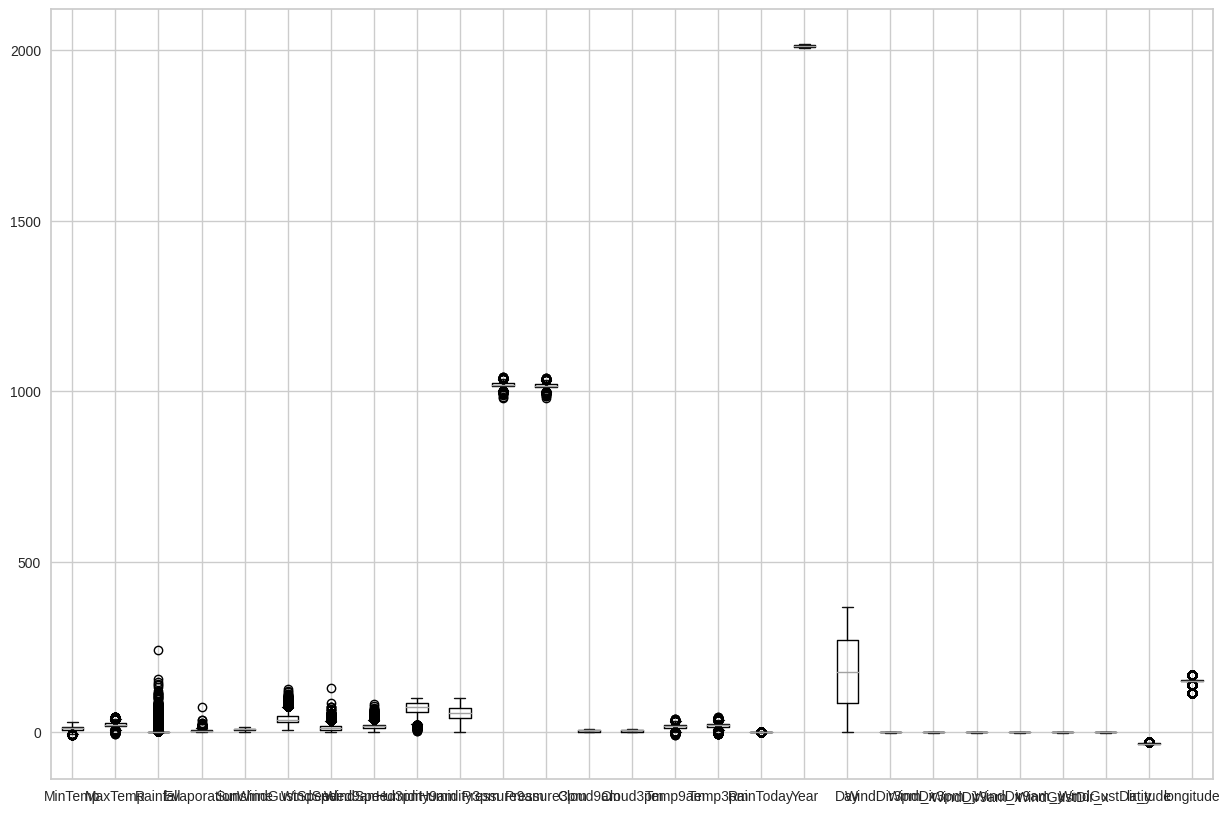

In [24]:
X_train.boxplot(figsize=(15, 10))

In [25]:
def reimpute_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Función que reemplaza los valores atípicos por los valores medios de la columna.
    Args:
        df (pd.DataFrame): DataFrame con los datos de entrenamiento.

    Returns:
        pd.DataFrame: DataFrame con los datos de entrenamiento con valores atípicos reemplazados por los valores medios de la columna.
    """
    for column in df.columns:
        if column == 'RainToday':
            continue

        Q1: float = df[column].quantile(0.25)
        Q3: float = df[column].quantile(0.75)
        IQR: float = Q3 - Q1

        lower_bound: float = Q1 - 1.5 * IQR
        upper_bound: float = Q3 + 1.5 * IQR

        median_value: float = df[column].median()

        df[column] = df[column].where((df[column] >= lower_bound) & (df[column] <= upper_bound), median_value)

    return df

X_train = reimpute_outliers(X_train)

## Eliminiación de valores faltantes y_train

In [26]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21572 entries, 3714 to 23654
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RainTomorrow  21172 non-null  float64
dtypes: float64(1)
memory usage: 337.1 KB


In [27]:
y_train.isna().sum()

,0
RainTomorrow,400


y_train presenta 21172 datos, de los cuales 400 son datos faltantes.

Esto representa aproximadamente 1.89% del dataset. Por eso se decide dropearlos.

In [28]:
X_train.reset_index(inplace=True)
y_train.reset_index(inplace=True)

# Se almacenan los indices cuyos valores no son Nan
indices_validos: pd.Index = y_train.dropna().index

Se filtran los mismos indices válidos en ambos conjuntos de train

In [29]:
X_train: pd.DataFrame = X_train.iloc[indices_validos]
y_train: pd.Series = y_train.iloc[indices_validos]

In [30]:
#Eliminación de columnas indices
X_train = X_train.drop(columns=['index'])
y_train = y_train.drop(columns=['index'])

## Eliminación de faltantes de y_test

Se dropean los valores nulos de y_test y X_test con los mismo indices. Ya que representan un 1.82% del total. Se tomó esta decisión porque, de tener valores nulos, genera conflicto con la matriz de confusión.

Lo que pretende hacer la matriz de confusión es intentar determinar en qué lugar están los valores nan y como no puede, falla.

In [31]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4623 entries, 1451 to 1527
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RainTomorrow  4539 non-null   float64
dtypes: float64(1)
memory usage: 72.2 KB


In [32]:
X_test.reset_index(inplace=True)
y_test.reset_index(inplace=True)

# Se almacenan los indices cuyos valores no son Nan
indices_validos: pd.Index = y_test.dropna().index

In [33]:
X_test: pd.DataFrame = X_test.iloc[indices_validos]
y_test: pd.Series = y_test.iloc[indices_validos]

In [34]:
# Eliminación de columnas indices
X_test = X_test.drop(columns=['index'])
y_test = y_test.drop(columns=['index'])

## Eliminación de faltantes de y_valid

Se dropean los valores nulos de y_valid y Y_test con los mismo indices. Ya que representan un 1.97% del total. Se tomó esta decisión porque, de tener valores nulos, genera conflicto con la matriz de confusión.

Lo que pretende hacer la matriz de confusión es intentar determinar en qué lugar están los valores nan y como no puede, falla.

In [35]:
y_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4623 entries, 4048 to 8054
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RainTomorrow  4532 non-null   float64
dtypes: float64(1)
memory usage: 72.2 KB


In [36]:
y_valid.isna().sum()

,0
RainTomorrow,91


In [37]:
X_valid.reset_index(inplace=True)
y_valid.reset_index(inplace=True)

# Se almacenan los indices cuyos valores no son Nan
indices_validos: pd.Index = y_valid.dropna().index

In [38]:
X_valid: pd.DataFrame = X_valid.iloc[indices_validos]
y_valid: pd.Series = y_valid.iloc[indices_validos]

In [39]:
# Eliminación de columnas indices
X_valid = X_valid.drop(columns=['index'])
y_valid = y_valid.drop(columns=['index'])

## Análisis de valores duplicados en X_train

Análisis duplicados en X_train. No se realiza con y_train ya que son 0 y 1 y daría duplicados.

In [40]:
X_train.duplicated().sum()

0

No se encuentran valores duplicados.

## Imputación de valores faltantes en X_train y X_test

Se realiza la imputación por medio de KNN. Se utiliza este porque al tener en cuenta los 5 vecinos más cercanos, es más idóneo que hacerlo por la mediana o cualquier estrategia de esa índole de la columna.

In [41]:
knn: KNNImputer = KNNImputer(n_neighbors=5)

X_train = pd.DataFrame(knn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(knn.transform(X_test), columns=X_test.columns)
X_valid = pd.DataFrame(knn.transform(X_valid), columns=X_valid.columns)

## Balanceo de Y_train

In [42]:
y_train.value_counts()

,count
RainTomorrow,
0.0,16276
1.0,4896


Se presenta un desbalance en el dataframe y_train, predominando ampliamente los días que no llueven.

In [43]:
print(f'Los días de lluvia del dataset y_train representan el {round(y_train.value_counts()[1]*100/y_train.shape[0],2)}%')

Los días de lluvia del dataset y_train representan el 23.12%


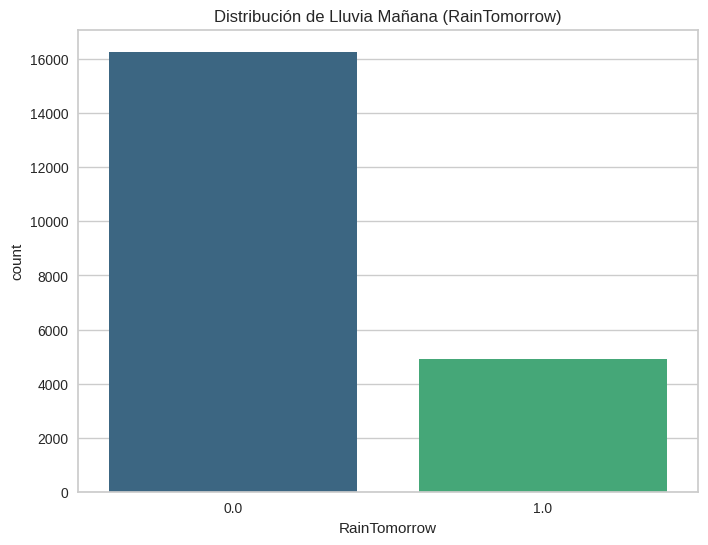

In [44]:
plt.figure(figsize=(8, 6))
sns.countplot(x='RainTomorrow', data=y_train, palette='viridis')
plt.title("Distribución de Lluvia Mañana (RainTomorrow)")
plt.show()


Podemos observar un claro desbalance, tal como lo anticipó el % de los días de lluvia sobre el total de días.


## Estandarizado

Se estanadariza usando Z-Score

In [45]:
scaler: StandardScaler = StandardScaler()

Se estandariza sin tener en cuenta la columna categórica 'Year'

In [46]:
X_train_year = X_train['Year']
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.drop('Year', axis=1)), columns=X_train.drop('Year', axis=1).columns)

X_test_year = X_test['Year']
X_test_scaled = pd.DataFrame(scaler.transform(X_test.drop('Year', axis=1)), columns=X_test.drop('Year', axis=1).columns)

X_valid_year = X_valid['Year']
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid.drop('Year', axis=1)), columns=X_valid.drop('Year', axis=1).columns)

X_train_scaled['Year'] = X_train_year
X_test_scaled['Year'] = X_test_year
X_valid_scaled['Year'] = X_valid_year



## Matriz de correlación

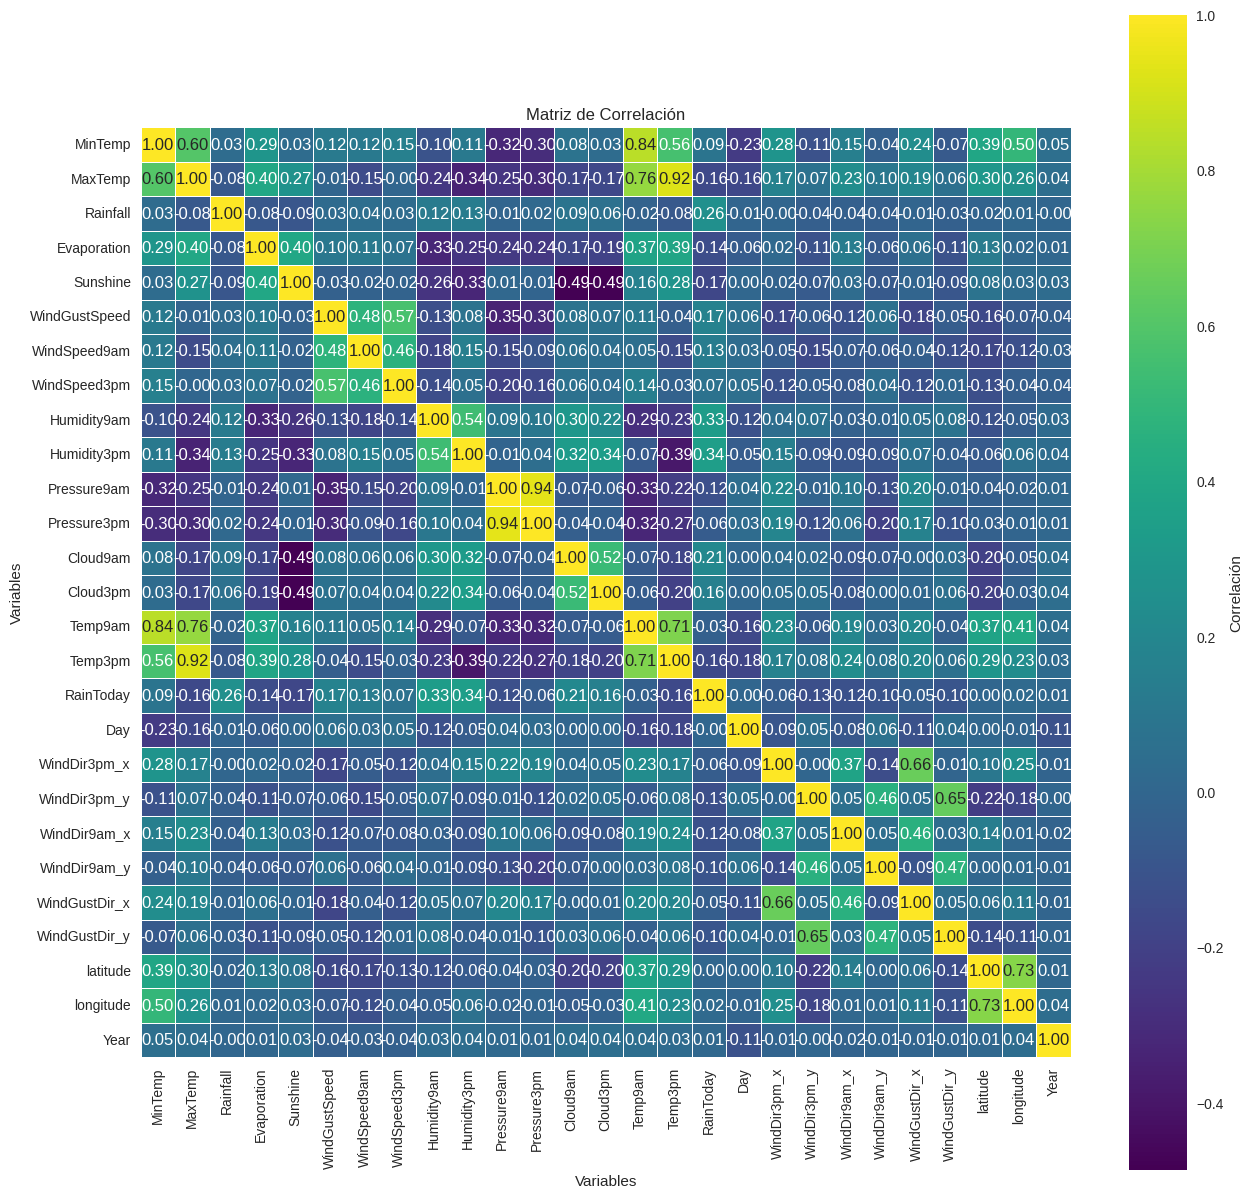

In [47]:
corr_matrix: np.ndarray = X_train_scaled.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='viridis',
            cbar_kws={'label': 'Correlación'},
            square=True,
            fmt='.2f',
            linewidths=0.5,
            linecolor='white')

plt.title('Matriz de Correlación')
plt.xlabel('Variables')
plt.ylabel('Variables')

plt.show()

Se encuentras correlaciones fuertes, destacando:

- Pressure9am - Pressure3pm
- MinTemp - Temp9am
- MaxTemp - Temp3pm
- MaxTemp - Temp9am
- Temp9am - Temp3pm

Estas correlaciones tienen sentido y reflejan patrones meteorológicos típicos de comportamiento de las variables relacionadas con la temperatura y la presión.


# Implementación de modelos

Dado que el dataset se encuentra altamente desbalanceado, se descarta el uso de Accuracy como metrica.

Por lo que analizará el modelo en base a Precision, recall, F1.

En una primera instancia, se analiza el modelo de regresión logistica


#### Dataset de comparación

Se crea el dataset para la comparación final entre todos los modelos generados. La métrica elegida es F1 ya que nos interesa diferenciar correctamente las clases y al mismo tiempo, la precisión de ambas.


In [48]:
df_modelos: pd.DataFrame = pd.DataFrame(columns=['Modelo', 'F1'])


### Regresión logística sin balance

In [49]:
y_test = y_test.astype(int)

Realizamos esto ya que en el conjunto y_test se codifica en 1 y 0 pero en formato np.float32 y debe ser entero.


In [50]:
y_test.isna().sum()

,0
RainTomorrow,0


In [51]:
# definimos funciona para mostrar los resultados
def mostrar_resultados(y_test: np.ndarray, pred_y: np.ndarray, title_: str, grafica: bool = True) -> np.ndarray:
      conf_matrix: np.ndarray = confusion_matrix(y_test, pred_y)

      if grafica:
        fig = px.imshow(conf_matrix,
            text_auto=True,
            title=title_,
            labels={'x':'Predicción', 'y':'Actual'},
            x=['No llueve', 'Llueve'],
            y=['No llueve', 'Llueve'])

        fig.show()

      return conf_matrix

In [52]:
logr_model = LogisticRegression(C=1.0, penalty='l2', random_state=1, solver="newton-cg")
logr_model.fit(X_train_scaled, y_train)

pred_y: np.ndarray = logr_model.predict(X_valid_scaled)

In [53]:
confusion_matrix_manual_model = mostrar_resultados(y_valid,pred_y, 'Matriz de Confusión sin balanceo')
confusion_matrix_manual_model

array([[2870,  628],
       [ 618,  416]])

La precisión general del modelo es bastante alta, pero hay un número significativo de falsos negativos, lo que indica que el modelo podría estar fallando en identificar algunas instancias positivas.
La alta especificidad sugiere que el modelo es efectivo para identificar negativos, mientras que la sensibilidad sugiere que se podría mejorar la identificación de positivos.

In [54]:
print(classification_report(y_valid, pred_y))

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82      3498
         1.0       0.40      0.40      0.40      1034

    accuracy                           0.73      4532
   macro avg       0.61      0.61      0.61      4532
weighted avg       0.73      0.73      0.73      4532



In [55]:
y_scores = logr_model.predict_proba(X_valid_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, y_scores)

In [56]:
auc(fpr, tpr)

0.6854928431057039

In [57]:
df_modelos.loc[len(df_modelos)] = ['Regresión Logística a mano sin balanceo', f1_score(y_valid, pred_y, average='weighted')]
df_modelos

,Modelo,F1
0,Regresión Logística a mano sin balanceo,0.725531


Cálculo de umbral óptimo por medio de estadística de Youden.

In [58]:
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

In [59]:
confusion_matrix_manual_model_optimal  = mostrar_resultados(
    y_valid,y_pred_optimal,
    'Matriz de Confusión sin balanceo, calculando umbral óptimo')

confusion_matrix_manual_model_optimal

array([[2205, 1293],
       [ 318,  716]])

Si bien con el umbral mejoramos los falsos positivos, la diferencia no es significativa.

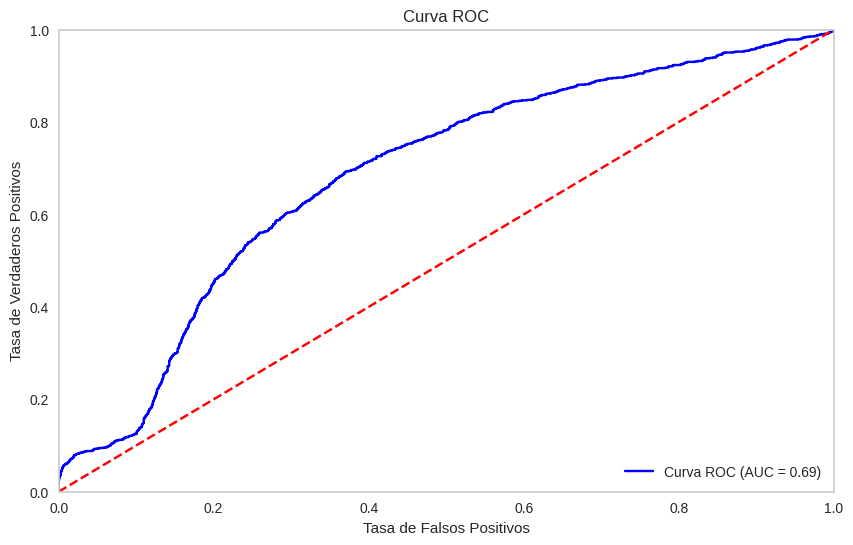

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

La curva ROC con un AUC de 0.69, indica que el modelo es capaz de distinguir correctamente los días en los que **NO llueve** de aquellos en los que sí, con un balance adecuado entre la detección correcta de lluvia y la minimización de falsas alarmas. Aunque no es perfecto, el modelo es bastante preciso en sus predicciones.

Sabiendo también las métricas de recall, f1-score, support sabemos que el modelo tiene un buen desempeño prediciendo cuándo no llueve pero malo con respecto a cuando sí llueve.

In [61]:
logr_model_balanced = LogisticRegression(C=1.0, penalty='l2',class_weight='balanced', random_state=1, solver="newton-cg")
logr_model_balanced.fit(X_train_scaled, y_train)

pred_y_balanced: np.ndarray = logr_model_balanced.predict(X_valid_scaled)

In [62]:
print(classification_report(y_valid, pred_y_balanced))

              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75      3498
         1.0       0.37      0.66      0.47      1034

    accuracy                           0.66      4532
   macro avg       0.62      0.66      0.61      4532
weighted avg       0.76      0.66      0.69      4532



Agrego métrica a df_modelos

In [63]:
df_modelos.loc[len(df_modelos)] = ['Regresión Logística youden v1', f1_score(y_valid, pred_y_balanced, average='weighted')]

In [64]:
auc(fpr, tpr)

0.6854928431057039

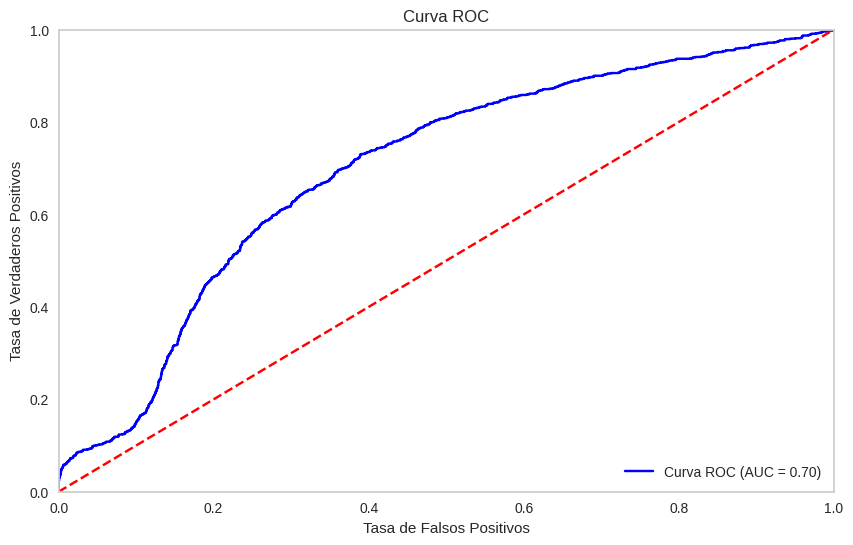

In [65]:
y_scores = logr_model_balanced.predict_proba(X_valid_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Se hizo una prueba de cambiar los parámetros de la funcion de LogisticRegresion. Si bien la curva es apenas distinta, el AUC es casi idéntico.

In [66]:
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

In [67]:
mostrar_resultados(y_valid,y_pred_optimal, 'Matriz de Confusión sin balanceo, calculando umbral óptimo V2')

array([[2137, 1361],
       [ 279,  755]])

La matriz de confusión nos ilustra que existe más falsos positivos y menos fasos negativos.

In [68]:
# Se agrega el modelo al dataset de comparación
df_modelos.loc[len(df_modelos)] = ['Regresión Logística youden v2', f1_score(y_valid, y_pred_optimal, average='weighted')]
df_modelos

,Modelo,F1
0,Regresión Logística a mano sin balanceo,0.725531
1,Regresión Logística youden v1,0.689226
2,Regresión Logística youden v2,0.667176


## Analisis de 'buen' o 'mal' fitting

El AUC refleja un buen desempeño general del modelo, indicando que predice correctamente en la mayoría de los casos. Sin embargo, hemos identificado que el modelo funciona mejor prediciendo los días en los que no llueve, mientras que muestra deficiencias al predecir los días en los que sí llueve. Este problema probablemente se deba a un desbalance en el conjunto de datos, donde los días sin lluvia podrían estar representados en mayor cantidad que los días con lluvia, lo que lleva al modelo a favorecer la clase mayoritaria.

## Validacion Cruzada
1. Se observa una disminución rápida en la precisión entre los primeros dos folds, lo que es inusual. Esto sugiere que los datos podrían no estar bien equilibrados o que el modelo no es consistente.
2. Las curvas de KFold y StratifiedKFold son casi idénticas, lo que indica que la estratificación no afecta significativamente la precisión en este conjunto de datos.
3. La precisión que cae a cero en el segundo fold sugiere problemas potenciales, como clases desbalanceadas, datos de baja calidad o configuraciones incorrectas en el entrenamiento.

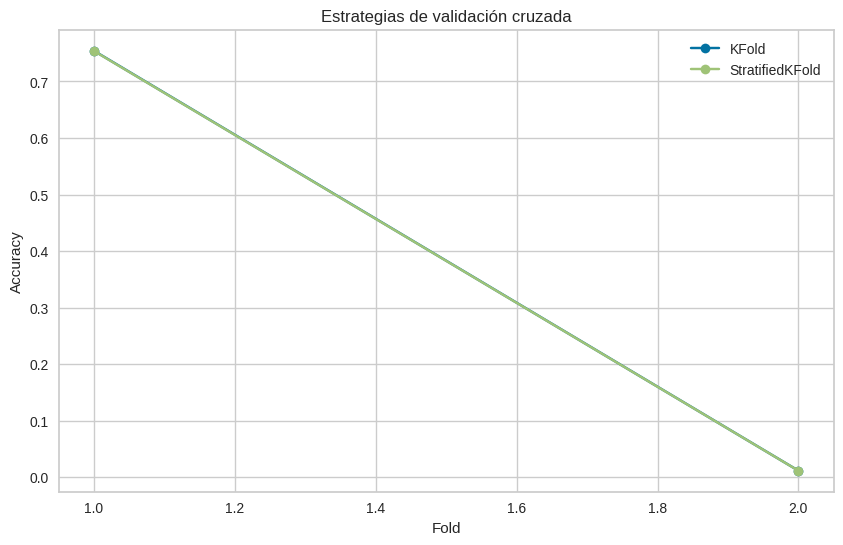

Estrategia: KFold - Media: 0.754, Desvío Estándar: 0.012
Estrategia: StratifiedKFold - Media: 0.754, Desvío Estándar: 0.011


In [69]:
cv_strategies: List[Tuple[str, Any]] = [
    ("KFold", KFold(n_splits=20, shuffle=True, random_state=42)),
    ("StratifiedKFold", StratifiedKFold(n_splits=20, shuffle=True, random_state=42))
]

results: dict = {}

for name, cv in cv_strategies:
    scores = cross_val_score(logr_model_balanced, X_train_scaled, y_train, cv=cv)
    results[name] = (scores.mean(), scores.std())

plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()

for name, (mean, std) in results.items():
    print(f"Estrategia: {name} - Media: {mean:.3f}, Desvío Estándar: {std:.3f}")

# Modelo base

Para esta ocasión elegimos un modelo de regresión lineal con una única variable. Elegimos la columna de 'RainToday' para entrenar el modelo.

Se definió un umbral para poder evaluar el modelo.

In [70]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled[['RainToday']], y_train)

lr_y_pred = lr_model.predict(X_valid[['RainToday']])

threshold = 0.5
lr_y_pred_binary = (lr_y_pred >= threshold).astype(int)

f1 = f1_score(y_valid, lr_y_pred_binary, average='weighted')
print(f'El F1-score ponderado es: {f1}')

El F1-score ponderado es: 0.6724564436760208


Con las métricas del modelo base, podemos compararlo con el modelo de regresión logística. El modelo de regresión lineal basado en una única variable, funciona de mejor manera que el de regresión logística con umbrales óptimos de youden pero peor que la hecha a mano.

In [71]:
# Se agrega el modelo al dataset de comparación
df_modelos.loc[len(df_modelos)] = ['Regresión Lineal', f1]
df_modelos

,Modelo,F1
0,Regresión Logística a mano sin balanceo,0.725531
1,Regresión Logística youden v1,0.689226
2,Regresión Logística youden v2,0.667176
3,Regresión Lineal,0.672456


# Optimización de Hiperparámetros

Se arma un diccionario para los parámetros a optimizar. Se utiliza RandomSearchCV para optimizar los parámetros. Este es utilizado debido a que es menos costoso que GridSearchCV.

In [72]:
parametros: dict[str, list[Any]] = {
    'penalty': ['l2', 'l1', 'elasticnet', None],
    'dual':[False, True],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'newton-cg'],
    'max_iter': [50,150,300, 500,1000, 2000,5000]
}

In [73]:
lr_model_randomizedCV: LogisticRegression = LogisticRegression()

scoring = {
    'F1': make_scorer(f1_score, average='weighted'),
    'Recall': make_scorer(recall_score, average='weighted')
}

random_search = RandomizedSearchCV(
    estimator=lr_model_randomizedCV,
    param_distributions=parametros,
    n_iter=50,
    scoring=scoring,
    refit='F1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Perform the search
random_search.fit(X_train_scaled, y_train['RainTomorrow'])

pred_y_randomizedCV = random_search.predict(X_valid_scaled)

# Get the best parameters and scores
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)
print("Best Recall Score:", random_search.cv_results_['mean_test_Recall'][random_search.best_index_])

Best Parameters: {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 5000, 'fit_intercept': False, 'dual': False, 'class_weight': None, 'C': 0.01}
Best F1 Score: 0.8101998459744774
Best Recall Score: 0.8266575353619627


In [74]:
print('Rendimiento de regresión logística con Randomized CV: \n')
print (classification_report(y_valid, pred_y_randomizedCV))
print('--------------------------------------------------------------------------------')
print('Rendimiento de regresión logística hecha anteriormente: \n')
print (classification_report(y_valid, y_pred_optimal))

Rendimiento de regresión logística con Randomized CV: 

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83      3498
         1.0       0.41      0.40      0.41      1034

    accuracy                           0.73      4532
   macro avg       0.62      0.62      0.62      4532
weighted avg       0.73      0.73      0.73      4532

--------------------------------------------------------------------------------
Rendimiento de regresión logística hecha anteriormente: 

              precision    recall  f1-score   support

         0.0       0.88      0.61      0.72      3498
         1.0       0.36      0.73      0.48      1034

    accuracy                           0.64      4532
   macro avg       0.62      0.67      0.60      4532
weighted avg       0.76      0.64      0.67      4532



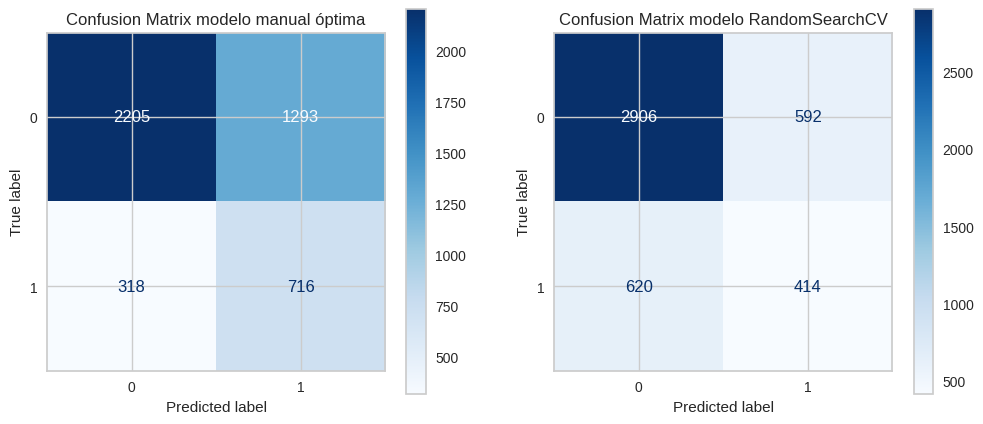

In [75]:
confusion_matrix_random_search = mostrar_resultados(y_valid,
                                                    pred_y_randomizedCV,
                                                      'Matriz de confusión de modelo obtenido con RandomSearchCV', grafica=False)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(confusion_matrix_manual_model_optimal).plot(ax=ax[0], cmap='Blues')
ax[0].set_title("Confusion Matrix modelo manual óptima")

ConfusionMatrixDisplay(confusion_matrix_random_search).plot(ax=ax[1], cmap='Blues')
ax[1].set_title("Confusion Matrix modelo RandomSearchCV")

plt.show()

El modelo realizado a mano con la optimización de Youden  tiene un rendimiento superior en la predicción de días de lluvia en comparación con el modelo ajustado hallado por RandomizedSearchCV. EL Recall en conjunto con el F1-score en la detección de días lluviosos mejora, lo que indica un mejor equilibrio del modelo. El recall para días de lluvia es considerablemente mayor en el modelo optimizado por Youden, la precisión general y el rendimiento equilibrado en ambas clases reflejan un modelo más robusto y confiable.

Esto se ve ilustrado en las matrices de confusión. Vemos que el modelo por RandomSearch acierta muy bien a cuando no llueve pero cuando llueve, el modelo optimizado tiene un rendimiento mucho mejor.

Le atribuimos esto a que los datos están desbalanceados.

In [76]:
# Se agrega el modelo al dataset de comparación
df_modelos.loc[len(df_modelos)] = ['Regresión Logística Randomized CV', recall_score(y_valid, pred_y_randomizedCV, average='weighted')]
df_modelos

,Modelo,F1
0,Regresión Logística a mano sin balanceo,0.725531
1,Regresión Logística youden v1,0.689226
2,Regresión Logística youden v2,0.667176
3,Regresión Lineal,0.672456
4,Regresión Logística Randomized CV,0.732568



# SHAP

In [77]:
shap.initjs()

In [78]:
explainer = shap.Explainer(
    logr_model, X_train_scaled, feature_names=X_train_scaled.columns
)
shap_values = explainer(X_valid_scaled)


## Análisis local

Para el análisis se usará el indice 150


In [79]:
index: int = 150

In [80]:
y_test.iloc[index]

,154
RainTomorrow,0


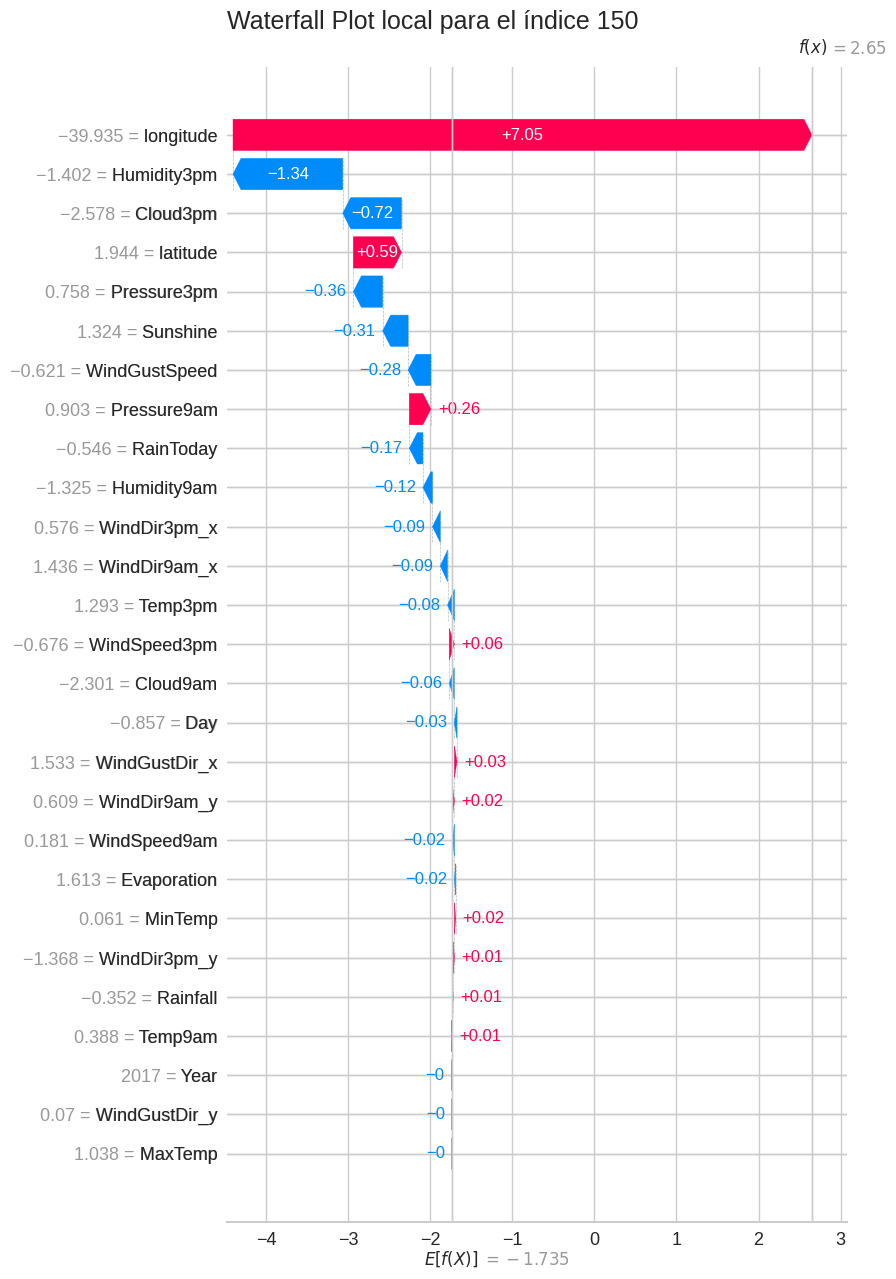

In [81]:
# Waterfall plot

plt.figure()
plt.title(f'Waterfall Plot local para el índice {index}', fontsize = 18, loc='left')
shap.plots.waterfall(shap_values[index], max_display=99, show=False)
plt.show()

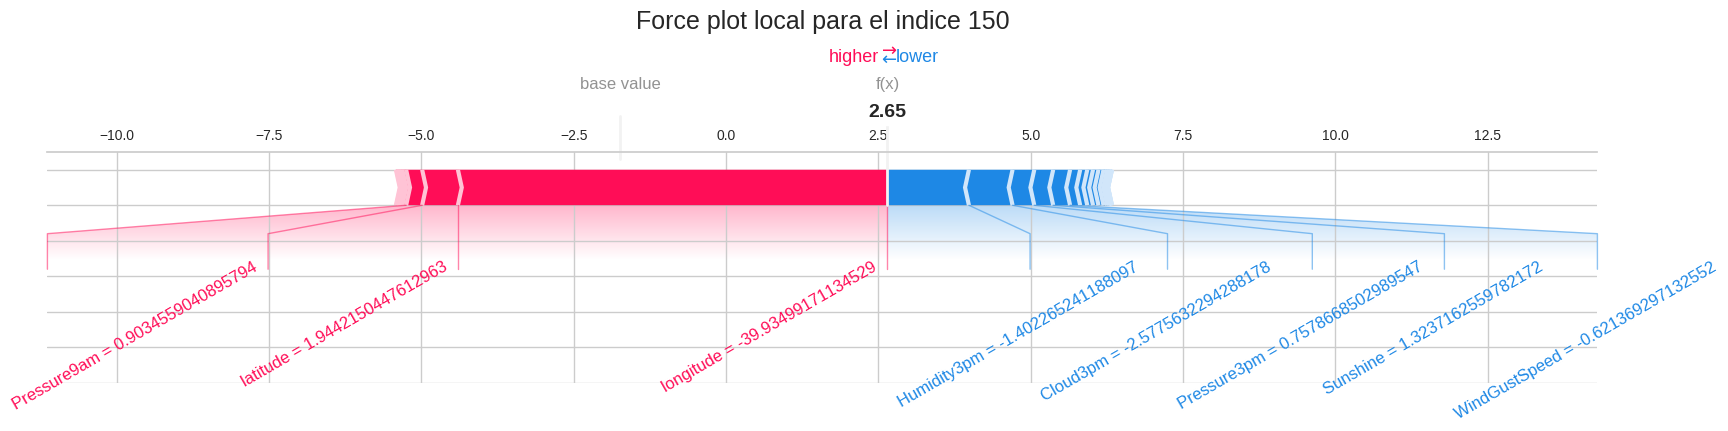

In [82]:
# Force plot
shap.plots.force(shap_values[index],show=False, matplotlib=True, text_rotation= 30)
plt.title(f'Force plot local para el indice {index}', y=1.50, fontsize = 18)
plt.show()

En este caso SHAP determinó significantes a la presión a las 9 am, la ubicación mediante latitud y longitud. Las mismas 'suman' al modelo. Por otro lado, la humedad a las 3 pm, la nubosidad y la presion a la misma hora, el sol y las velocidades de los vientos no aportaron demasiada información.


## Analisis global

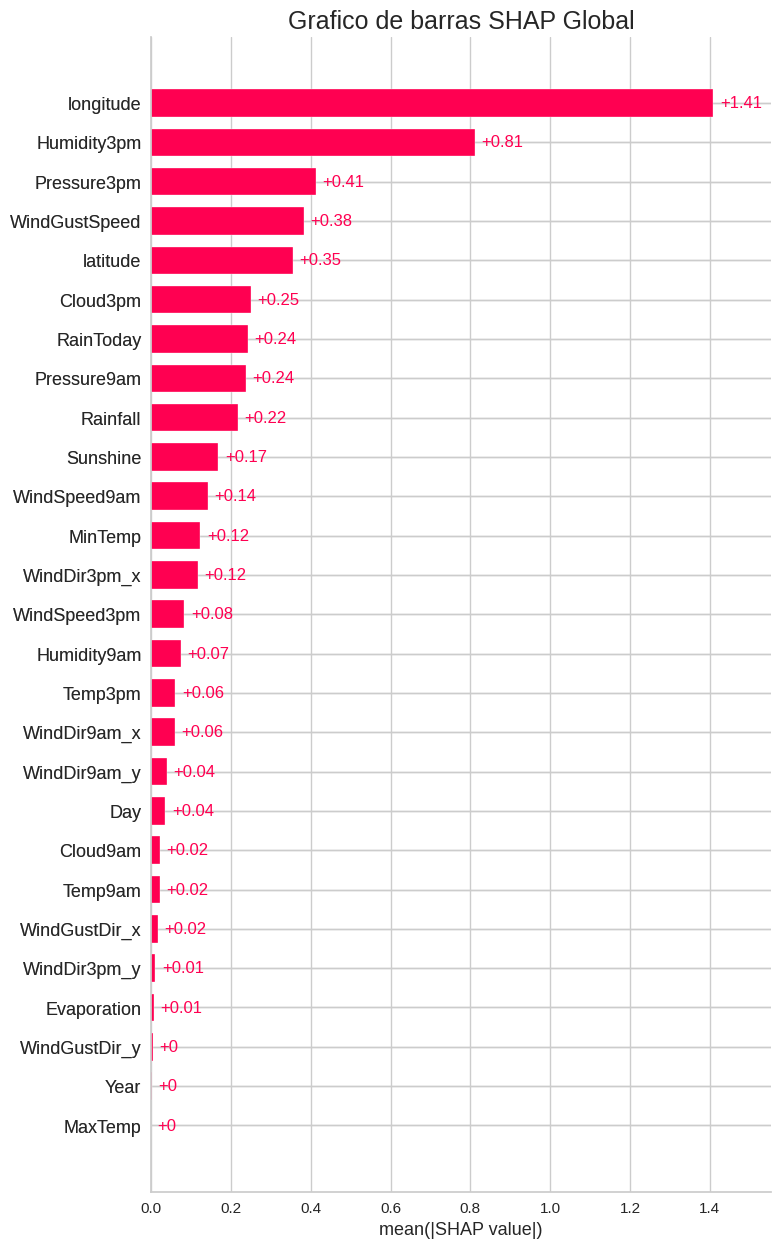

In [83]:
plt.figure()
shap.plots.bar(shap_values, max_display=99, show=False)
plt.title('Grafico de barras SHAP Global', fontsize=18, loc = 'center')
plt.show()

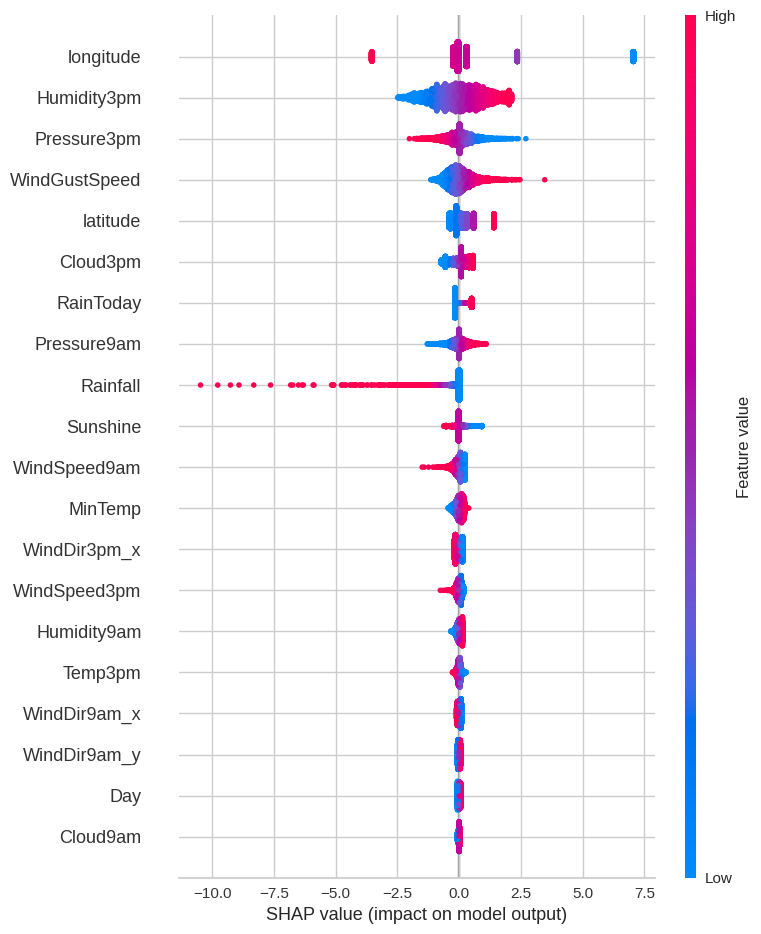

Text(0.5, 1.0, 'Summary plot SHAP Global')

In [84]:
shap.summary_plot(shap_values, X_valid_scaled, plot_type="dot", show=True)
plt.title('Summary plot SHAP Global', fontsize = 18)


A nivel global, SHAP identifica la ubicación, la humedad, la Presión y la Velocidad del viento como las variables más influyentes. Por el contrario, los años, la evaporación, las direcciones del viento y la ubicación se consideran las menos relevantes.

Notamos que obtuvimos resultados distintos que en el análisis local, como lo puede ser el valor asignado a temperatura máxima registrada en el día. Esto resalta la importancia de combinar ambos enfoques para obtener una visión más completa y precisa del modelo y sus predicciones.

## Conclusiones de SHAP

**Características clave:**
latitud y longitud, Humidity3pm, WindGustSpeed y Pressure3pm son las más influyentes en el modelo. Esto sugiere que las condiciones de humedad y viento juegan un papel crucial en la tarea de predicción.

**Estrategias futuras:** Se puede considerar estas características para optimizar o simplificar el modelo, ya que parecen tener la mayor influencia en las decisiones del modelo.

# Auto ML

Se implementa Pycaret para la confección de un modelo de auto ml, a fin de comparar con el hecho de forma manual.

Se Dropean las filas que contienen un RainTomorrow nan.

In [85]:
df_pure = df.dropna(subset=['RainTomorrow'])

Inicialización del modelo de auto machine learning. Se setea un session_id para tener siempre el mismo resultado.

In [86]:
auto_ml = setup(df_pure, target='RainTomorrow', session_id=42, use_gpu = True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Description,Value
0,Session id,42
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(30243, 28)"
4,Transformed data shape,"(30243, 28)"
5,Transformed train set shape,"(21170, 28)"
6,Transformed test set shape,"(9073, 28)"
7,Numeric features,27
8,Rows with missing values,71.6%
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

Comparamos los modelos para elegir el mejor. Utilizamos 'F1' como métrica de evaluación ya que el dataset está desbalanceado.  

In [87]:
best_model_auto_ml = compare_models(sort='F1')
best_model_auto_ml

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8456,0.8666,0.5408,0.7257,0.6196,0.5253,0.5344,0.5550
lightgbm,Light Gradient Boosting Machine,0.8481,0.8707,0.5252,0.7470,0.6164,0.5253,0.5382,0.4520
rf,Random Forest Classifier,0.8450,0.8655,0.4834,0.7635,0.5917,0.5020,0.5221,4.1620
gbc,Gradient Boosting Classifier,0.8435,0.8573,0.4805,0.7580,0.5878,0.4972,0.5171,6.5440
et,Extra Trees Classifier,0.8441,0.8658,0.4750,0.7657,0.5861,0.4965,0.5181,2.2330
qda,Quadratic Discriminant Analysis,0.8126,0.8242,0.5288,0.6128,0.5675,0.4488,0.4509,0.1120
ada,Ada Boost Classifier,0.8313,0.8359,0.4661,0.7091,0.5621,0.4632,0.4791,1.5120
lda,Linear Discriminant Analysis,0.8262,0.8333,0.4646,0.6868,0.5538,0.4509,0.4644,0.1850
nb,Naive Bayes,0.7929,0.8038,0.5473,0.5557,0.5513,0.4167,0.4168,0.0660
knn,K Neighbors Classifier,0.8244,0.7929,0.4571,0.6827,0.5474,0.4438,0.4576,0.8570


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

Creamos el modelo de autoML

In [88]:
auto_ml_model = create_model(best_model_auto_ml)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8526,0.8631,0.5508,0.7486,0.6347,0.5450,0.5551
1,0.8399,0.8653,0.5407,0.7018,0.6108,0.5121,0.5190
2,0.8366,0.8554,0.5203,0.6995,0.5967,0.4970,0.5056
3,0.8526,0.8698,0.5772,0.7320,0.6455,0.5541,0.5603
4,0.8441,0.8597,0.5203,0.7314,0.6081,0.5142,0.5258
5,0.8460,0.8751,0.5528,0.7196,0.6253,0.5305,0.5378
6,0.8465,0.8712,0.5558,0.7211,0.6277,0.5331,0.5402
7,0.8427,0.8636,0.5233,0.7247,0.6078,0.5126,0.5232
8,0.8498,0.8735,0.5294,0.7522,0.6214,0.5312,0.5440


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Optimizamos F1, métrica que utilizaremos para comparar este modelo generado por AutoML con el modelo hecho de forma manual con el óptimo.

In [89]:
tuned_model = tune_model(auto_ml_model, n_iter=10, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7898,0.8705,0.7703,0.5331,0.6301,0.4900,0.5062
1,0.8002,0.8696,0.7663,0.5504,0.6406,0.5073,0.5207
2,0.7818,0.8564,0.7581,0.5209,0.6175,0.4721,0.4884
3,0.7931,0.8675,0.7581,0.5390,0.6301,0.4921,0.5059
4,0.7936,0.8650,0.7744,0.5389,0.6355,0.4979,0.5138
5,0.7879,0.8666,0.7703,0.5301,0.6280,0.4867,0.5033
6,0.7997,0.8730,0.7769,0.5495,0.6437,0.5100,0.5248
7,0.7931,0.8632,0.7627,0.5395,0.6319,0.4939,0.5082
8,0.7955,0.8693,0.7708,0.5429,0.6370,0.5006,0.5155


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Teniendo en cuenta las métricas obtenidas con la regresión logística, observamos que el rendimiento es inferior.

Esto se debe a que el pre procesado de los datos está hecho de forma automática, sin tener en cuenta cuestiones específicas del problema como lo hemos logrado mediante la interpretación de cada una de las columnas.

Si miramos F1-score para cada modelo:
- F1-score modelo LogReg a mano: 0.73.
- F1-score para modelo de Auto ML: 0.63 (media).

También, cabe destacar que los modelos son distintos. AutoML situa a XGBClassifier como su mejor opción, mientras que la Regresión Logística alcanzada por este mismo algoritmo tiene un rendimiento con un F1-score inferior (0.55).

In [90]:
df_modelos.loc[len(df_modelos)] = ['AutoML XGBClassifier', 0.63]
df_modelos

,Modelo,F1
0,Regresión Logística a mano sin balanceo,0.725531
1,Regresión Logística youden v1,0.689226
2,Regresión Logística youden v2,0.667176
3,Regresión Lineal,0.672456
4,Regresión Logística Randomized CV,0.732568
5,AutoML XGBClassifier,0.630000


# Balanceo de datos
Se utiliza ADASYN, por una cuestión que prioriza los datos que son más difíciles de clasificar, teniendo en cuenta la distribución local de los datos de la clase que está siendo oversampleada.


In [91]:
adasyn: ADASYN = ADASYN(sampling_strategy = 'minority', random_state=42)

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)

Visualizamos el constraste entre los datos balanceados y desbalanceados

In [92]:
y_train_resampled.value_counts()

,count
RainTomorrow,
0.0,16276
1.0,15875


In [93]:
y_train.value_counts()

,count
RainTomorrow,
0.0,16276
1.0,4896


Para evaluarlo de forma rápida, hago una regresión logística con los parámetros obtenidos de hacer RandomizedCV.

In [94]:
lr_balanced = LogisticRegression(tol = 0.0001, solver = 'liblinear', penalty = 'l2', fit_intercept = False, dual = False, C = 0.01)

lr_balanced.fit(X_train_resampled, y_train_resampled)

y_pred_lr_balanced = lr_balanced.predict(X_valid_scaled)

In [95]:
print('Nuevo reporte con dataset balanceado:')
print(classification_report(y_valid, y_pred_lr_balanced))
print('------------------------------------------------------')
print('Reporte con dataset desbalanceado:')
print(classification_report(y_valid, y_pred_optimal))

Nuevo reporte con dataset balanceado:
              precision    recall  f1-score   support

         0.0       0.87      0.65      0.74      3498
         1.0       0.36      0.67      0.47      1034

    accuracy                           0.65      4532
   macro avg       0.61      0.66      0.60      4532
weighted avg       0.75      0.65      0.68      4532

------------------------------------------------------
Reporte con dataset desbalanceado:
              precision    recall  f1-score   support

         0.0       0.88      0.61      0.72      3498
         1.0       0.36      0.73      0.48      1034

    accuracy                           0.64      4532
   macro avg       0.62      0.67      0.60      4532
weighted avg       0.76      0.64      0.67      4532



Hay una mejora sobre las predicciones de los días de lluvia (1). Esta mejoría es a costa de desmejorar el recall de los días que no lleuven.

In [96]:
mostrar_resultados(y_valid, y_pred_lr_balanced, 'Matriz de confusión de modelo con datos balanceados', True)
mostrar_resultados(y_valid, pred_y, 'Matriz de confusión de modelo con datos desbalanceados', True)

array([[2870,  628],
       [ 618,  416]])


# Redes Neuronales

In [97]:
class F1Score(tf.keras.metrics.Metric):
    """
    Custom F1-Score metric for binary classification (common F1).
    """
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        # Initialize counters for true positives, false positives, and false negatives
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predicted probabilities to binary predictions (0 or 1)
        y_pred = tf.round(y_pred)  # Round predictions to 0 or 1

        # Update the true positives, false positives, and false negatives
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        # Calculate precision and recall
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())

        # Calculate the F1-score (common F1-score)
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        # Reset all variables to zero at the start of each epoch
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

class NeuralNetwork:
    def __init__(self, epochs: int = 50, batch_size: int = 16, learning_rate: float = 0.01, dropout_rate: float = 0.3):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate  # New dropout rate parameter
        self.model = None

    def build_model(self, input_shape: int, num_classes: int = 1):
        """
        Build a simple neural network for binary classification, with dropout layers for regularization.

        Args:
            input_shape: The number of input features (X_train.shape[1]).
            num_classes: Number of output classes, typically 1 for binary classification.
        """
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation='leaky_relu', input_shape=(input_shape,)),
            tf.keras.layers.Dense(64, activation='leaky_relu'),
            tf.keras.layers.Dense(32, activation='leaky_relu'),
            tf.keras.layers.Dense(num_classes, activation='sigmoid')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=[F1Score()])

        self.model = model

    def train(self, X_train: pd.DataFrame, y_train: pd.DataFrame, X_valid: pd.DataFrame, y_valid: pd.DataFrame):
        """
        Train the model on the training data.

        Args:
            X_train: Training data features.
            y_train: Training data labels.
            X_valid: Validation data features.
            y_valid: Validation data labels.

        Returns:
            History of the training and validation loss.
        """
        history = self.model.fit(X_train, y_train,
                                 validation_data=(X_valid, y_valid),
                                 epochs=self.epochs,
                                 batch_size=self.batch_size)
        return history.history['loss'], history.history['val_loss']

    def evaluate(self, X_test, y_test):
        """
        Evaluate the model on the test set and compute the F1-score.

        Args:
            X_test: Test data features.
            y_test: Test data labels.
        """
        # Make predictions on the test set
        y_pred = self.model.predict(X_test)

        # Convert probabilities to binary predictions (0 or 1)
        binary_predictions = (y_pred > 0.5).astype(int)

        # Calculate F1-score using sklearn
        f1 = f1_score(y_test, binary_predictions)
        print(f"Test F1-score: {f1:.4f}")

    def predict(self, X_new):
        """
        Make predictions on new data.

        Args:
            X_new: New data to make predictions on.
        """
        predictions = self.model.predict(X_new)
        binary_predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary values
        return binary_predictions

    def plot_loss(self, train_loss, val_loss):
        """
        Plot training and validation loss.

        Args:
            train_loss: Training loss values.
            val_loss: Validation loss values.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()


In [98]:
nn_model: NeuralNetwork = NeuralNetwork(epochs=50, batch_size=512, learning_rate=0.01)

input_shape: int = X_train_resampled.shape[1]

nn_model.build_model(input_shape=input_shape, num_classes=y_train_resampled.shape[1])
history_imb = nn_model.train(X_train_resampled, y_train_resampled, X_valid_scaled, y_valid)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - f1_score: 0.4903 - loss: 70.7920 - val_f1_score: 0.4376 - val_loss: 0.6324
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.5289 - loss: 0.7063 - val_f1_score: 0.3956 - val_loss: 0.8421
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6514 - loss: 0.6360 - val_f1_score: 0.4950 - val_loss: 0.5573
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.6487 - loss: 0.6103 - val_f1_score: 0.5156 - val_loss: 0.6752
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6807 - loss: 0.5839 - val_f1_score: 0.5349 - val_loss: 0.6229
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6937 - loss: 0.5737 - val_f1_score: 0.5572 - val_loss: 0.5505
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6824 - loss: 0.5894 - val_f1_score: 0.4563 - val_loss: 0.4509
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6812 - loss: 0.5841 - val_f1_score: 0.4762 - val_los

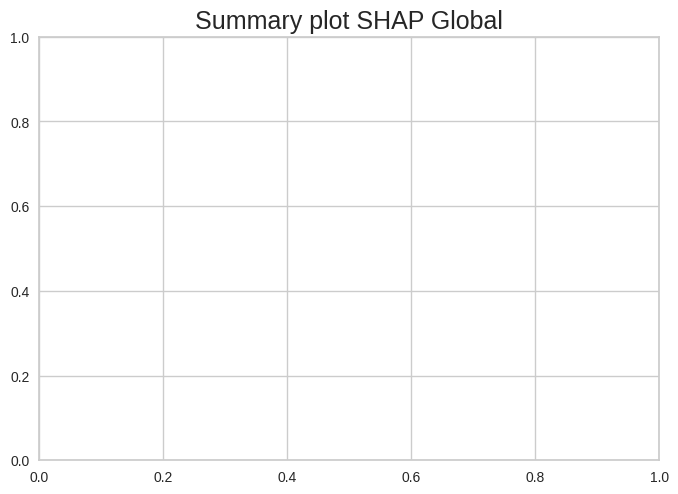

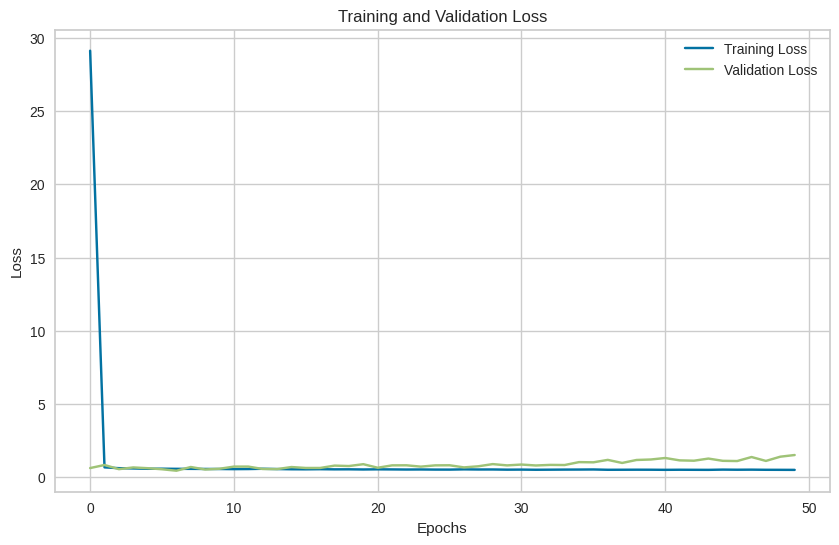

In [99]:
nn_model.plot_loss(history_imb[0], history_imb[1])

Podemos ver que si bien alcanzamos un recall de 0.75 el entrenamiento no es óptimo y hay margen de mejora. Los picos no son óptimos. De forma ideal tendríamos curvas decrecientes conforme avanzan las épocas.

In [100]:
y_pred_nn: np.ndarray = nn_model.predict(X_valid_scaled)

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [101]:
print(classification_report(y_valid, y_pred_nn))
mostrar_resultados(y_valid, y_pred_nn, 'Matriz de confusión de red neuronal con datos balanceados', True)

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      3498
         1.0       0.45      0.35      0.39      1034

    accuracy                           0.76      4532
   macro avg       0.64      0.61      0.62      4532
weighted avg       0.74      0.76      0.74      4532



array([[3062,  436],
       [ 674,  360]])

In [102]:
# Se agrega el modelo al dataset de comparación
df_modelos.loc[len(df_modelos)] = ['Red Neuronal', f1_score(y_pred=y_pred_nn, y_true=y_valid, average='macro')]
df_modelos

,Modelo,F1
0,Regresión Logística a mano sin balanceo,0.725531
1,Regresión Logística youden v1,0.689226
2,Regresión Logística youden v2,0.667176
3,Regresión Lineal,0.672456
4,Regresión Logística Randomized CV,0.732568
5,AutoML XGBClassifier,0.630000
6,Red Neuronal,0.620000



##  Optimización de parametros usando Optuna

tomo como métrica el recall para evaluar la calidad de la predicción.

In [103]:
def objective(trial):
    input_shape = X_train_resampled.shape[1]

    num_layers = trial.suggest_int('num_layers', 1, 6)
    model = tf.keras.models.Sequential()

    # Add layers dynamically based on the suggested number of layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)

        if i == 0:
            model.add(tf.keras.layers.Dense(num_units, input_shape=(input_shape,)))
            model.add(tf.keras.layers.LeakyReLU())
        else:
            model.add(tf.keras.layers.Dense(num_units))
            model.add(tf.keras.layers.LeakyReLU())

        # Add dropout after each dense layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model with F1Score as the evaluation metric
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score()])

    # Train the model
    model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_valid_scaled, y_valid),
        epochs=10, batch_size=512, verbose=0
    )

    # Evaluate the model on the validation set
    score = model.evaluate(X_valid_scaled, y_valid, verbose=0)
    return score[1]  # Return the F1-score (second element in score)

# Create and optimize the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best parameters found:", best_params)

[I 2024-12-31 17:00:39,402] A new study created in memory with name: no-name-d9e54397-4c53-4af5-acc7-040f63137da7
[I 2024-12-31 17:00:46,690] Trial 0 finished with value: 0.44209885597229004 and parameters: {'num_layers': 1, 'n_units_layer_0': 33}. Best is trial 0 with value: 0.44209885597229004.
[I 2024-12-31 17:00:59,080] Trial 1 finished with value: 0.46905314922332764 and parameters: {'num_layers': 5, 'n_units_layer_0': 123, 'n_units_layer_1': 10, 'n_units_layer_2': 68, 'n_units_layer_3': 111, 'n_units_layer_4': 99}. Best is trial 1 with value: 0.46905314922332764.
[I 2024-12-31 17:01:11,960] Trial 2 finished with value: 0.49293380975723267 and parameters: {'num_layers': 5, 'n_units_layer_0': 39, 'n_units_layer_1': 104, 'n_units_layer_2': 109, 'n_units_layer_3': 51, 'n_units_layer_4': 87}. Best is trial 2 with value: 0.49293380975723267.
[I 2024-12-31 17:01:21,084] Trial 3 finished with value: 0.445026159286499 and parameters: {'num_layers': 2, 'n_units_layer_0': 98, 'n_units_layer

Best parameters found: {'num_layers': 4, 'n_units_layer_0': 48, 'n_units_layer_1': 111, 'n_units_layer_2': 57, 'n_units_layer_3': 35}


Me guardo la salida de la red que dió el mejor parámetro en las ejecuciones que fueron cambiando.

In [104]:
# Best parameters found: {'num_layers': 5, 'n_units_layer_0': 107, 'n_units_layer_1': 105, 'n_units_layer_2': 94, 'n_units_layer_3': 38, 'n_units_layer_4': 12}

Creamos la red neuronal con los mejores parámetros optimizados con Optuna.

In [105]:
class OptimizedNeuralNetwork:
    def __init__(self, epochs=50, batch_size=16, learning_rate=0.01):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self, input_shape, num_classes=1):
        """
        Builds a neural network model using the best hyperparameters from optimization.

        Parameters:
            input_shape: The number of features in the input dataset (X_train.shape[1]).
            num_classes: Output classes, typically 1 for binary classification.
        """
        model = tf.keras.models.Sequential()

        # Layer configuration based on best parameters
        model.add(tf.keras.layers.Dense(107, activation='leaky_relu', input_shape=(input_shape,)))
        model.add(tf.keras.layers.Dense(105, activation='leaky_relu'))
        model.add(tf.keras.layers.Dense(94, activation='leaky_relu'))
        model.add(tf.keras.layers.Dense(38, activation='leaky_relu'))
        model.add(tf.keras.layers.Dense(12, activation='leaky_relu'))

        # Output layer for binary classification with sigmoid activation
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary output

        # Compile the model with Adam optimizer, binary crossentropy loss, and F1-score metric
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score()])

        self.model = model

    def train(self, X_train, y_train, X_valid, y_valid):
        """
        Train the model on the training data.

        Parameters:
            X_train: Features for training.
            y_train: Labels for training.
            X_valid: Features for validation.
            y_valid: Labels for validation.

        Returns:
            History of training and validation loss.
        """
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=self.epochs, batch_size=self.batch_size
        )
        return history.history['loss'], history.history['val_loss']

    def evaluate(self, X_test, y_test):
        """
        Evaluate the model on the test set and print F1-score.

        Parameters:
            X_test: Features for testing.
            y_test: Labels for testing.
        """
        # Make predictions on the test set
        y_pred = self.model.predict(X_test)

        # Convert probabilities to binary predictions
        binary_predictions = (y_pred > 0.5).astype(int)

        # Calculate the F1-score using sklearn's f1_score
        f1 = f1_score(y_test, binary_predictions)
        print(f"Test F1-score: {f1:.4f}")

        return f1

    def predict(self, X_new):
        """
        Make predictions on new data.

        Parameters:
            X_new: New data to make predictions on.
        """
        predictions = self.model.predict(X_new)
        binary_predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary values
        return binary_predictions

    def plot_loss(self, train_loss, val_loss):
        """
        Plot the training and validation loss curves.

        Parameters:
            train_loss: List of training loss values.
            val_loss: List of validation loss values.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

utilizo un batch_size de 256 para obtener un rendimiento superior y un entrenamiento rápido.

In [106]:
best_nn = OptimizedNeuralNetwork(epochs=30, batch_size=512, learning_rate=0.1)

best_nn.build_model(input_shape=X_train_resampled.shape[1], num_classes=y_train_resampled.shape[1])

history_best_nn = best_nn.train(X_train_resampled, y_train_resampled, X_valid_scaled, y_valid)

y_pred_best_nn = best_nn.predict(X_valid_scaled)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - f1_score: 0.4895 - loss: 26032.2598 - val_f1_score: 0.3715 - val_loss: 1398.0880
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.5169 - loss: 295.4590 - val_f1_score: 0.3715 - val_loss: 243.2976
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.5054 - loss: 109.9512 - val_f1_score: 0.3701 - val_loss: 5.5232
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.5978 - loss: 3.1010 - val_f1_score: 0.3777 - val_loss: 8.8579
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.6088 - loss: 1.6344 - val_f1_score: 0.4685 - val_loss: 2.0621
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6092 - loss: 0.7683 - val_f1_score: 0.5199 - val_loss: 2.0356
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.6168 - loss: 0.7913 - val_f1_score: 0.4354 - val_loss: 2.6900
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.6285 - loss: 0.7624 - val_f1_score: 0.44

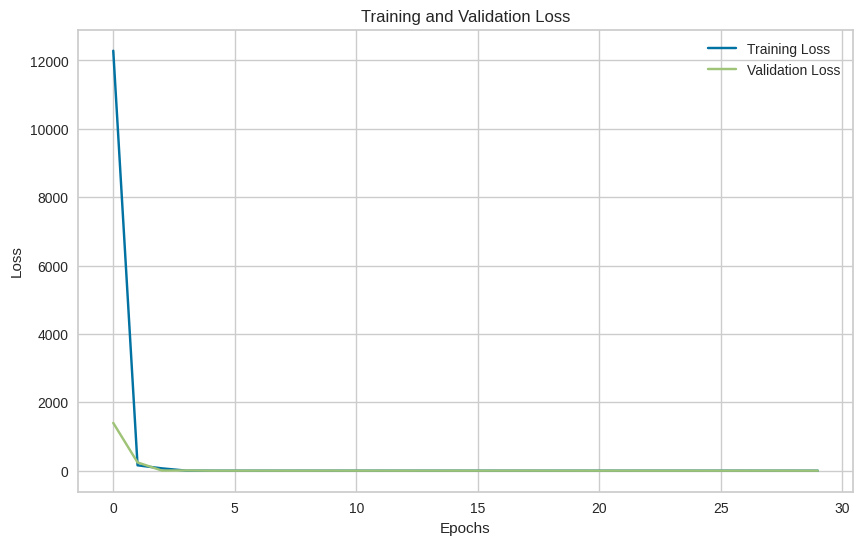

In [107]:
best_nn.plot_loss(history_best_nn[0], history_best_nn[1])

El modelo aprendió bien desde un inicio y no tiene grandes oscilaciones. El contraste con respecto a la red neuronal anterior se ve claramente y este es superior.

In [108]:
print(classification_report(y_valid, y_pred_best_nn))

              precision    recall  f1-score   support

         0.0       0.85      0.71      0.77      3498
         1.0       0.37      0.57      0.45      1034

    accuracy                           0.68      4532
   macro avg       0.61      0.64      0.61      4532
weighted avg       0.74      0.68      0.70      4532



In [109]:
# Se agrega el modelo al dataset de comparación
df_modelos.loc[len(df_modelos)] = ['Red Neuronal Optuna', recall_score(y_valid, y_pred_best_nn)]
df_modelos

,Modelo,F1
0,Regresión Logística a mano sin balanceo,0.725531
1,Regresión Logística youden v1,0.689226
2,Regresión Logística youden v2,0.667176
3,Regresión Lineal,0.672456
4,Regresión Logística Randomized CV,0.732568
5,AutoML XGBClassifier,0.630000
6,Red Neuronal,0.620000
7,Red Neuronal Optuna,0.567698


## K-folds

Se realiza validación cruzada utilizando el método StratifiedKFold. Se evalua el rendimiento de la red neuronal con respecto los distintos conjuntos de datos del dataset.

In [110]:
sfolder: StratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

recall_metrics: dict[str, float] = {}
f1_metrics: dict[str, float] = {}

nn_fold = OptimizedNeuralNetwork(epochs=30, batch_size=512, learning_rate=0.1)

gen: Generator = sfolder.split(X_valid_scaled, y_valid)

count: int = 1

for train_index, test_index in gen:

    X_train_fold_nn, X_test_fold_nn = X_train_scaled.iloc[train_index], X_valid_scaled.iloc[test_index]
    y_train_fold_nn, y_test_fold_nn = y_train.iloc[train_index], y_valid.iloc[test_index]


    nn_fold.build_model(input_shape=X_train_fold_nn.shape[1], num_classes=y_train_fold_nn.shape[1])

    nn_fold.train(X_train_fold_nn, y_train_fold_nn, X_test_fold_nn, y_test_fold_nn)

    y_pred_nn_fold = nn_fold.predict(X_test_fold_nn)

    recall_metrics[f'Recall {count}'] = recall_score(y_test_fold_nn, y_pred_nn_fold, average='macro')
    f1_metrics[f'F1 - {count}'] = f1_score(y_test_fold_nn, y_pred_nn_fold, average='macro')

    print(f'Métricas del conjunto nro: {count}')
    print(f'Recall: {recall_metrics[f"Recall {count}"]}')
    print(f'F1: {f1_metrics[f"F1 - {count}"]}')
    print("--------------------------------------------------------------------------------")

    count += 1

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 500ms/step - f1_score: 0.3008 - loss: 6096.2490 - val_f1_score: 0.3716 - val_loss: 53914.6250
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.3411 - loss: 21539.4551 - val_f1_score: 0.0000e+00 - val_loss: 107.9016
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.2297 - loss: 682.0595 - val_f1_score: 0.0000e+00 - val_loss: 893.1738
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.1918 - loss: 1158.4232 - val_f1_score: 0.0000e+00 - val_loss: 7123.0068
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.1312 - loss: 5150.7666 - val_f1_score: 0.0000e+00 - val_loss: 969.2499
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.1418 - loss: 1135.7391 - val_f1_score: 0.0000e+00 - val_loss: 241.0223
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.2387 - loss: 730.6453 - val_f1_score: 0.0000e+00 - val_loss: 640.7034
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.2507 - 

Podemos ver que el recall classification report de la red neuronal optimizada entrenada y testeada no está demasiado alejado, ya que es 0.75. Aunque podemos observar en conjuntos puntuales como el nro. 5 conu un recall inferior con 0.66.


## SHAP

Se analiza el modelo de Red Neuronal con mejores parámetros generado mediante Optuna

In [111]:
explainer_nn = shap.Explainer(
    best_nn.model, X_train_resampled, feature_names=X_train_resampled.columns
)
shap_values_nn = explainer_nn(X_valid_scaled)

PermutationExplainer explainer: 4533it [07:23, 10.09it/s]                          



## Análisis local

In [112]:
index = 150

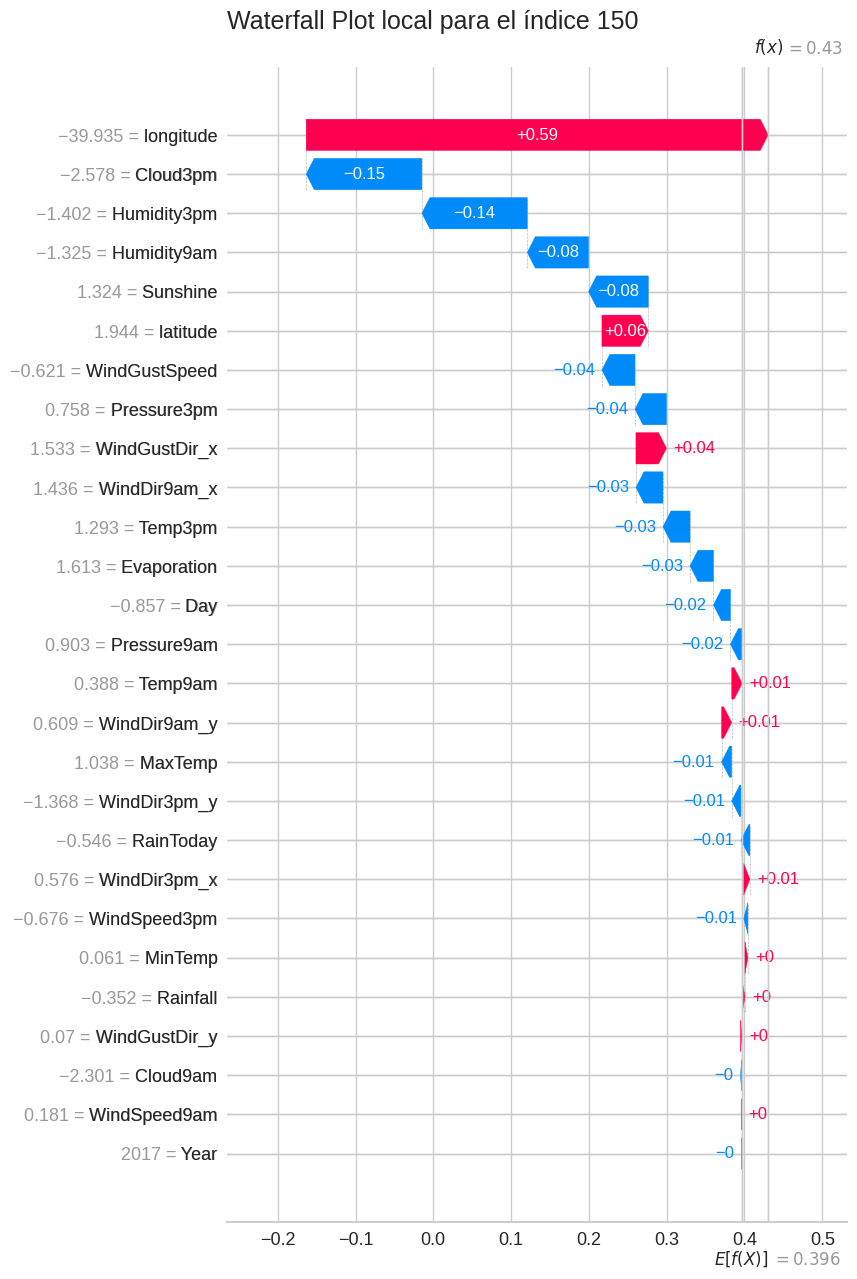

In [113]:
# Waterfall plot
plt.figure()
plt.title(f'Waterfall Plot local para el índice {index}', fontsize = 18, loc='left')
shap.plots.waterfall(shap_values_nn[index], max_display=99, show=False)
plt.show()

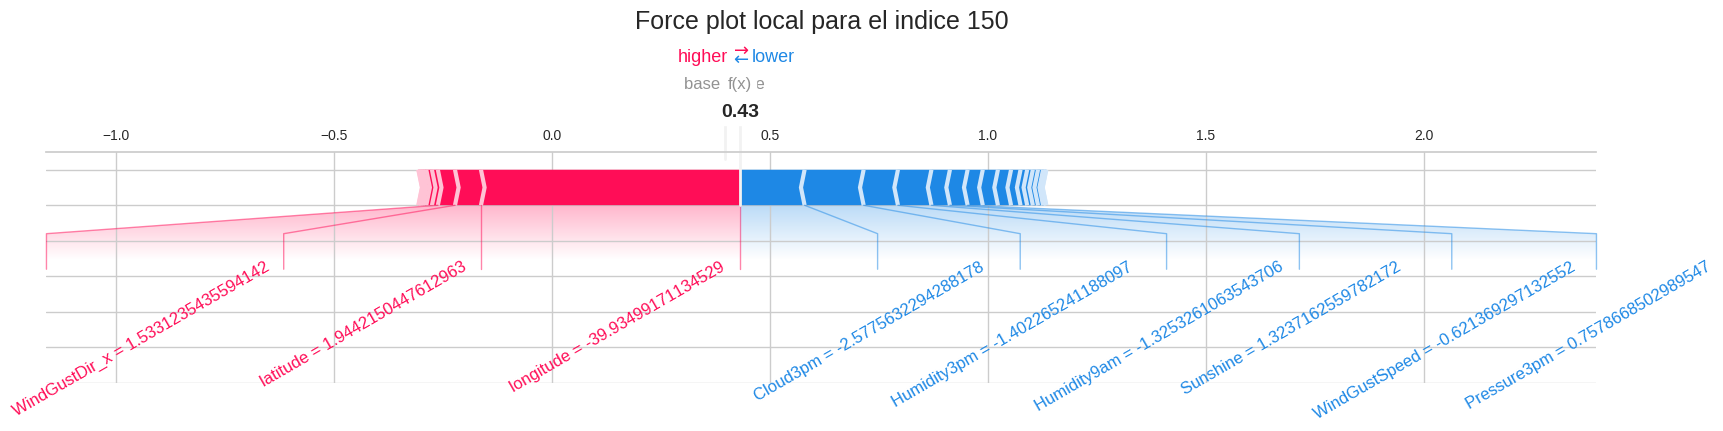

In [114]:
# Force plot
shap.plots.force(shap_values_nn[index],show=False, matplotlib=True, text_rotation= 30)
plt.title(f'Force plot local para el indice {index}', y=1.50, fontsize = 18)
plt.show()


## Análisis global

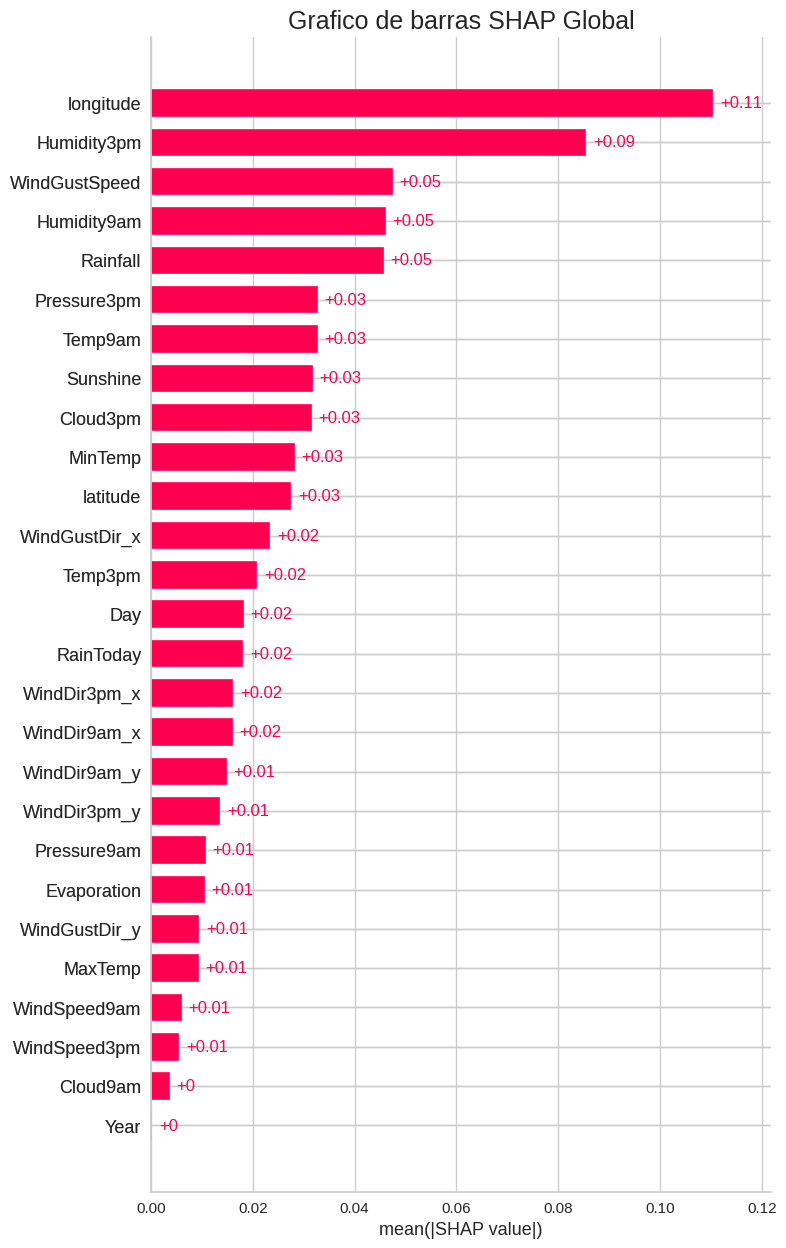

In [115]:
plt.figure()
shap.plots.bar(shap_values_nn, max_display=99, show=False)
plt.title('Grafico de barras SHAP Global', fontsize=18, loc = 'center')
plt.show()

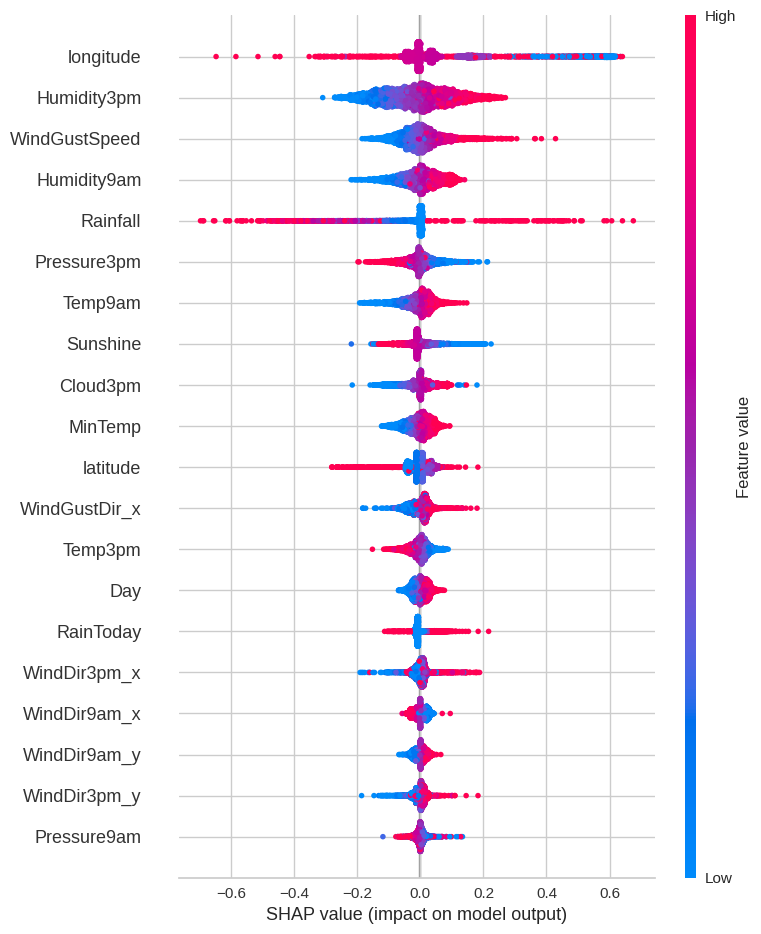

Text(0.5, 1.0, 'Summary plot SHAP Global')

In [116]:
shap.summary_plot(shap_values_nn, X_valid_scaled, plot_type="dot", show=True)
plt.title('Summary plot SHAP Global', fontsize = 18)

Se observa que SHAP asigna ponderaciones diferentes en el caso de Redes Neuronales comparado con la Regresión Logística. Uno de los principales cambios es que ahora todas las variables, excepto la columna ‘Year_2007’, son consideradas relevantes y poseen mayor peso en el análisis. No obstante, el orden de importancia cambia, ya que para las Redes Neuronales, los atributos más destacados según SHAP son la Humedad, las dos mediciones de Presión y la Dirección del viento.

En cuanto al análisis local del índice 150, tambien se encuentran cambios significativos, tanto en la importancia individual de cada atributo como en su orden de relevancia.


# Comparación final de modelos

La métrica elegida es Recall.

Se crea un dataset con todos los modelos generados con la finalidad de mostrar sus métricas y poder compararlos.

In [117]:
df_modelos = df_modelos.sort_values(by='F1', ascending = False)
df_modelos['F1'] = df_modelos['F1'].round(2)

In [118]:
# Gráfico de barras
fig = px.bar(
    df_modelos,
    x='F1',
    y='Modelo',
    title='Comparación de F1 por Modelo',
    labels={'Recall': 'F1', 'Modelo': 'Modelo'},
    text='F1',
    color='Modelo'
)
fig.show()


# Exportado de modelos

In [123]:
# Guardar el modelo de la Red Neuronal
with open(MODEL_PATH+'model_nn.h5', 'wb') as file:
    pickle.dump(best_nn.model, file)

# Guardar el modelo de Regresión Logística
with open(MODEL_PATH+'logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(logr_model, file)

# Conclusiones Finales

Se comenzó el trabajo con técnicas de preprocesamiento de los datos, donde se analizaron los atributos del dataset y se analizó la presencia de valores faltantes y atípicos.

El dataset inicial contaba con un desbalance grande de los datos, donde la gran mayoría de los datos indicaban que no llovería. Si bien no vimos necesario el balanceo a la hora de la Regresión Logistica, los datos fueron luego balanceados para la utilización de la Red Neuronal.

Durante el trascurso del trabajo, se realizaron diversas comparaciones entre modelos, optimizando parámetros y utilizando modelos como el de AutoML para un completo analisis. Ademas, se evaluó SHAP local y global para comprender aquellas caracteristicas que cada modelo consideraba más relevantes.

En nuestro caso, la Regresión Logística sin parámetros optimizados fue la que mejor Recall obtuvo, incluso mejor que la Red Neuronal, ya que no se logró llegar a una Red que funcione de manera correcta y no tienda al sobreajuste.